# Look at runs with multiple nudges 
Useful for getting better estimate of energy change per nudge

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
pd.set_option('display.max_columns',500)

In [2]:
df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")

/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57317/1971075393.py:1: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57317/1971075393.py:2: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57317/1971075393.py:3: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")


In [3]:
# select runs with multiple nudges. Not removing runs with backlash, but manually go through to make sure nudges are monotonic. Some 45/135 runs are flagged as backlash, when it seems like there isn't any
def select_data(df_in):
    df_out = df_in[(df_in['goodRun'])&(df_in['RunHasNudge'])&(df_in['TotalNudges_thisRun']>=1)]
    return df_out

In [4]:
df_2020_good = select_data(df_2020)
df_2023_good = select_data(df_2023)
df_2025_good = select_data(df_2025)

In [5]:
print(df_2020_good['GONI:ROLL'].value_counts())
print(df_2020_good['CBREM:PLANE'].value_counts())

GONI:ROLL
 34.50    459078
-10.50    400132
 0.00      14680
 29.55      9966
 10.00       191
 20.00        65
Name: count, dtype: int64
CBREM:PLANE
1    461271
2    404648
0     18193
Name: count, dtype: int64


In [6]:
# copy viz code from other notebook (or make it a utility aviailble to all would be better)
nudge_list_2020 = df_2020_good['RunNumber'].unique()
nudge_list_2023 = df_2023_good['RunNumber'].unique()
nudge_list_2025 = df_2025_good['RunNumber'].unique()

In [7]:
print(nudge_list_2020)

[72102 72105 72107 72109 72112 72116 72119 72127 72130 72133 72138 72142
 72145 72158 72160 72173 72176 72178 72179 72190 72246 72251 72257 72258
 72260 72264 72265 72266 72273 72274 72283 72285 72294 72297 72302 72363
 72367 72370 72375 72388 72406 72410 72420 72423 72424 72434 72650 72653
 72657 72658 72659 72666 72673 72677 72678 72684 72686 72703 72707 72708
 72719 72722 72725 72730 72732 72739 72742 72745 72749 72754 72757 72761
 72771 72773 72780 72781 72796 72798 72812 72814 72815 72816 72824 72827
 72828 72835 72837 72841 72848 72850 72852 72854 72855 72859 72868 72871
 72882 72887 72889 72909 72916 72917 72920 72923 72928 72930 73039 73041
 73045 73051 73055 73056 73058 73062 73066 73067 73073 73078 73088 73093
 73108 73121 73123 73126 73130 73147 73151 73160 73166 73167 73171 73173
 73175 73178 73182 73184 73188 73191 73210 73212 73214 73217 73225 73227
 73230 73263 73266]


In [8]:
print(df_2020_good.columns)

Index(['Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE', 'GONI:ROLL',
       'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y', 'GONI:Y.RBV',
       'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW', 'GONI:YAW.RBV', 'AC:X',
       'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY', 'EBEAM:X', 'EBEAM:Y',
       'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC', 'CBREM:ENERGY', 'RADIATOR:ID',
       'RADIATOR:NAME', 'goodRun', 'TimeStamp', 'RunHasNudge',
       'NudgeDuringRun', 'NudgeOccurred', 'TotalNudgeSize_thisRun',
       'NudgeSequence', 'NudgeSequenceReduced_Correct',
       'NudgeSequenceReduced_Naive', 'TotalNudges_thisRun',
       'RunHasAbnormalNudge', 'RunHasBacklash', 'ConfigChange_inProgress',
       'BacklashNudge', 'NudgeNumber', 'NudgePitchSize', 'NudgeYawSize',
       'PitchMotionSize', 'YawMotionSize', 'MotionDone', 'NudgeEnSize_10s',
       'CBREM:ENERGY_LAG_ADJUSTED'],
      dtype='object')


In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statistics
pd.set_option('display.max_columns',500)


# plot energy vs time for all nudges that arent backlash 
# subplot has size of change in pitch/yaw
def plot_run(df_in, runNumber):

    print("plotting for run ",runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600
    roll_0_90 = -10.5
    roll_45_135 = 34.5

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    df_run = df_in[df_in['RunNumber']==runNumber]
    df_run_nudges = df_run[(df_run['NudgeOccurred'])&(~df_run['BacklashNudge'])]
    nudge_list = df_run_nudges['NudgeNumber'].unique()

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    
    set_energy_drawn = False
    nudge_label_set = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []

    first_nudge_time = -1000
    max_nudge_time = 0

    print("Total number of nudges this run is ",df_run['TotalNudges_thisRun'].unique())
    print("Nudge list is ",nudge_list)
    print("Nudge has backlash count",df_run['BacklashNudge'].value_counts())
    print("Nudge occurred value counts: ",df_run['NudgeOccurred'].value_counts())
    
    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        nudge_time = df_this_nudge['TimeStamp'].min()
        print('Nudge number',seq,'occurs at time',nudge_time)

        if first_nudge_time==-1000:
            first_nudge_time = nudge_time

        current_pitchDiff = df_this_nudge['NudgePitchSize'].unique()[0]    
        current_yawDiff = df_this_nudge['NudgeYawSize'].unique()[0]

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time

        # plot the nudge with a vertical red line, add label if label not set yet
        if not nudge_label_set:
            ax1.axvline(nudge_time,color='r',linestyle='--',label='Nudge')
            nudge_label_set = True
        else:
            ax1.axvline(nudge_time,color='r',linestyle='--')
        
        # draw the desired energy and a green shaded +/- 10 MeV band
        if not set_energy_drawn:
            ax1.axhline(y=expectedE,color='g',linestyle='--',label='Set Energy')
            ax1.axhspan(expectedE-10,expectedE+10,color='g',alpha=0.1)
            set_energy_drawn = True
           
    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_in[(df_in['RunNumber']==runNumber)&(df_in['DAQ:STATUS']==2)]

    # initialize to large value. If daq never turned on, defaults to first nudge time
    daq_on_time = 10000
    set_daq_on_time = False
    if not df_daq_on.empty:
        daq_on_time = df_daq_on['TimeStamp'].min()
        set_daq_on_time = True
        print('daq on at time',daq_on_time)


    ax2.plot(nudge_times,yawDiffs,label='YawDiff',marker='o')
    ax2.plot(nudge_times,pitchDiffs,label='PitchDiff',marker='o')
    ax2.set_ylabel('Difference (Degrees)')
    plt.xlabel("Time Stamp (s)")
    ax2.legend()
    
    if set_daq_on_time:
        ax1.axvline(daq_on_time,color='black',label='DAQ On')

    # want the later of the daq turning on and the last nudge
    end_time = max(daq_on_time,max_nudge_time)
    # want the earliest of the daq turning on and the first nudge
    first_time = min(first_nudge_time,daq_on_time)
    
    df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=(first_time-30))&(df_in['TimeStamp']<=(end_time+30))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]

    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))

    
    print("Unique CBREM:PLANE values:",df_vis['CBREM:PLANE'].unique())
    plane_values = df_vis['CBREM:PLANE'].mode()
    roll_values = df_vis['GONI:ROLL'].mode()
    # get radiator name and orientation, strip deg and add plane info
    radiator_val = df_vis['RADIATOR:NAME'].mode()[0]
    if "Undefined" not in radiator_val:
        radiator_val = radiator_val.strip('deg')


    if radiator_val=="Undefined":
        # this indicates a communication issue in EPICS, as Undefined is set in cleanAndConvert for bad values of inputs
        # reset using known roll vals for 0/90 and 45/135
        print("Undefined radiator name is most common, value counts are:")
        print(df_vis['RADIATOR:NAME'].value_counts())
        print("most common roll value is ",roll_values[0])
        
        if roll_values[0]==roll_0_90:
            radiator_val = "0/90" 
        elif roll_values[0]==roll_45_135:
            radiator_val = "45/135"
        print("resetting radiator_val to ",radiator_val)

    if plane_values[0]==1:
        radiator_val+='PARA '
    elif plane_values[0]==2:
        radiator_val+='PERP '

    print("plane_values are",plane_values)
    print('roll_values are',roll_values)
    print('roll values are',df_vis['GONI:ROLL'].value_counts())
    print('roll values are',df_in[df_in['RunNumber']==runNumber]['GONI:ROLL'].value_counts())

    titleStr = 'Run '+str(runNumber)+" "+radiator_val
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("Photon Energy (GeV)")
    ax1.legend()

    plt.savefig("plots/multiNudge/plot_run_"+str(runNumber)+".pdf")
 
    plt.show()

    plt.clf()


In [10]:
# if a plot has no nudges drawn, it means all nudges were backlash
#for runVal in nudge_list_2020:
#    plot_run(df_2020_good,runVal)

plotting for run  72274
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    5079
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5078
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 268.0
daq on at time 142.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    185
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    5079
Name: count, dtype: int64


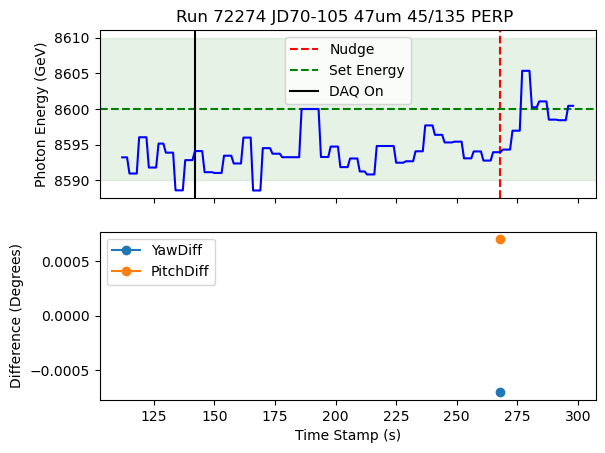

should have  [1] nudges for run 72274
energy change is 5.802000000001499
num_nudges_better is 1.0
energy change per nudge for run  72274 is 5.802000000001499
plotting for run  72297
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    7036
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7034
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 3520.0
Nudge number 3 occurs at time 3566.0
daq on at time 1763.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    1613
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    7037
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

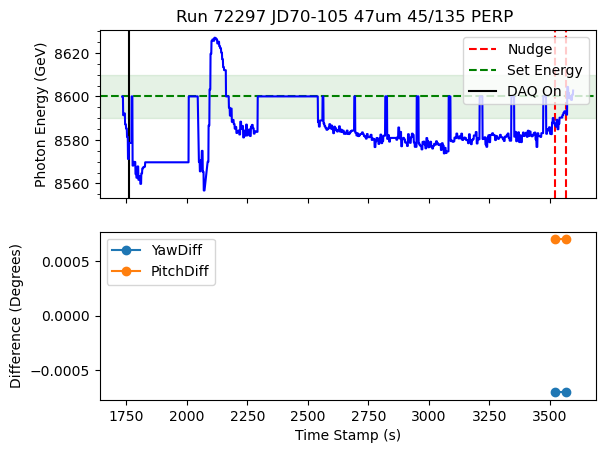

should have  [3] nudges for run 72297
energy change is 13.127999999998792
num_nudges_better is 2.0
energy change per nudge for run  72297 is 6.563999999999396
plotting for run  72410
Total number of nudges this run is  [7]
Nudge list is  [2 3 4 5 6 7]
Nudge has backlash count BacklashNudge
False    6725
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6719
True        7
Name: count, dtype: int64
Nudge number 2 occurs at time 416.0
Nudge number 3 occurs at time 430.0
Nudge number 4 occurs at time 444.0
Nudge number 5 occurs at time 451.0
Nudge number 6 occurs at time 475.0
Nudge number 7 occurs at time 483.0
daq on at time 299.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    234
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    6726
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

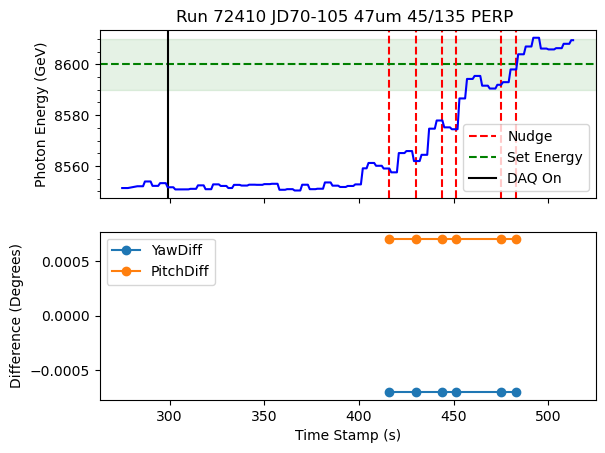

should have  [7] nudges for run 72410
energy change is 48.24200000000019
num_nudges_better is 5.9
energy change per nudge for run  72410 is 8.176610169491557
plotting for run  72657
Total number of nudges this run is  [8]
Nudge list is  [4 5 6 7 8]
Nudge has backlash count BacklashNudge
False    6752
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6747
True        8
Name: count, dtype: int64
Nudge number 4 occurs at time 686.0
Nudge number 5 occurs at time 697.0
Nudge number 6 occurs at time 705.0
Nudge number 7 occurs at time 708.0
Nudge number 8 occurs at time 723.0
daq on at time 502.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    114
Name: count, dtype: int64
roll values are GONI:ROLL
 34.5    6675
-10.5      80
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

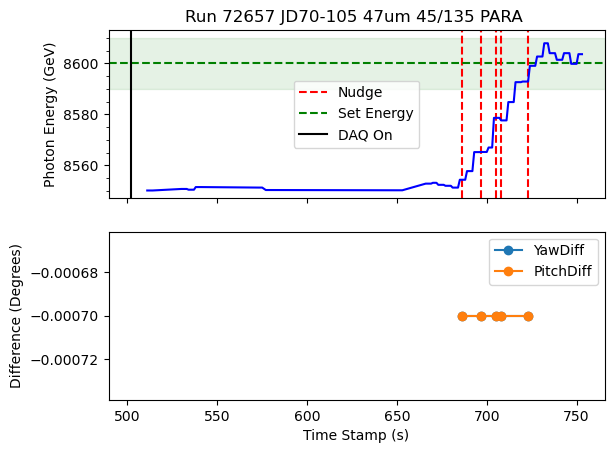

should have  [8] nudges for run 72657
energy change is 47.844999999999345
num_nudges_better is 4.9
energy change per nudge for run  72657 is 9.76428571428558
plotting for run  72745
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    5978
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5977
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 1800.0
daq on at time 411.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    540
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    5979
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

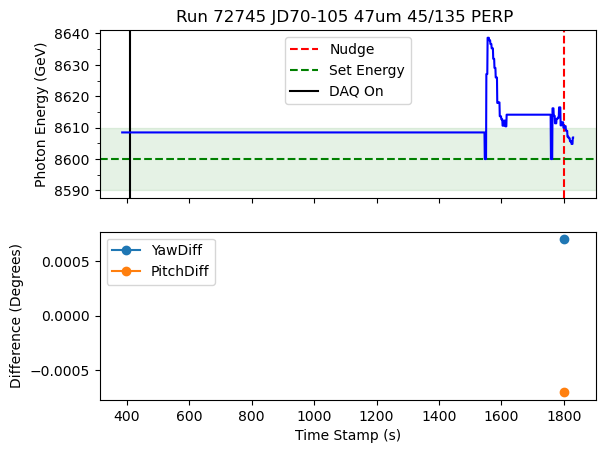

should have  [2] nudges for run 72745
energy change is 3.7660000000014406
num_nudges_better is 1.0
energy change per nudge for run  72745 is 3.7660000000014406
plotting for run  72773
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    7429
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7428
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 1354.0
daq on at time 1519.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    188
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    7430
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

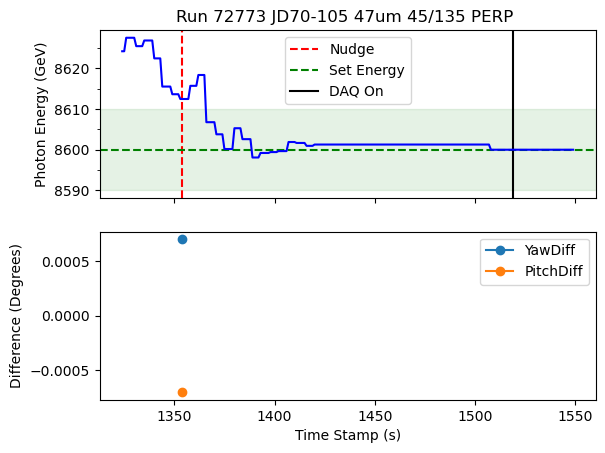

should have  [2] nudges for run 72773
energy change is 8.728000000000975
num_nudges_better is 1.0
energy change per nudge for run  72773 is 8.728000000000975
plotting for run  72816
Total number of nudges this run is  [5]
Nudge list is  [4 5]
Nudge has backlash count BacklashNudge
False    3193
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3191
True        5
Name: count, dtype: int64
Nudge number 4 occurs at time 97.0
Nudge number 5 occurs at time 111.0
daq on at time 219.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    182
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    3196
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

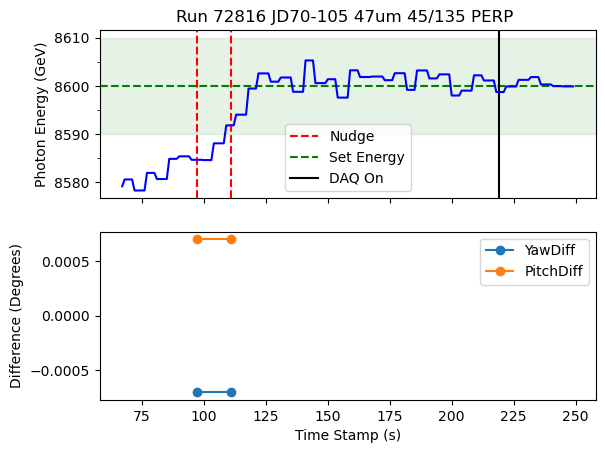

should have  [5] nudges for run 72816
energy change is 17.200000000000728
num_nudges_better is 2.0
energy change per nudge for run  72816 is 8.600000000000364
plotting for run  73073
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    2510
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2509
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 333.0
daq on at time 143.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    200
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    2511
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

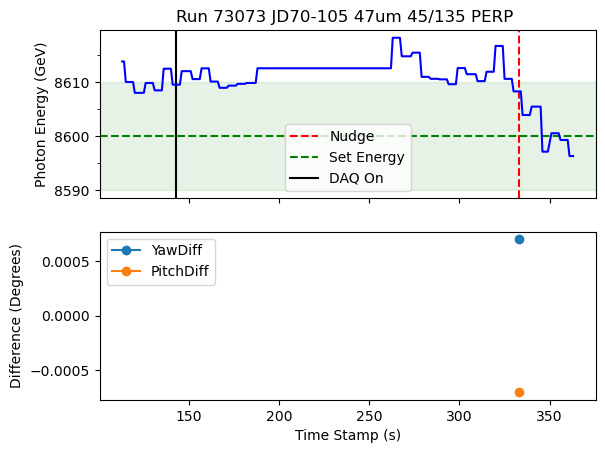

should have  [2] nudges for run 73073
energy change is 9.9325000000008
num_nudges_better is 1.0
energy change per nudge for run  73073 is 9.9325000000008
plotting for run  73088
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    2477
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2475
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 2198.0
Nudge number 3 occurs at time 2202.0
daq on at time 469.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    1626
Name: count, dtype: int64
roll values are GONI:ROLL
34.5    2478
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

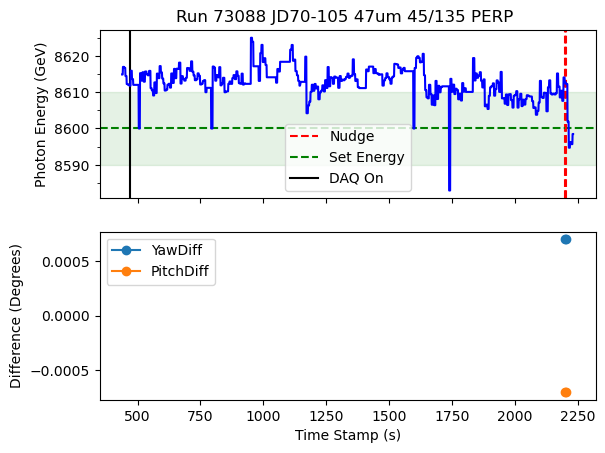

should have  [3] nudges for run 73088
energy change is 17.774999999999636
num_nudges_better is 2.0
energy change per nudge for run  73088 is 8.887499999999818
plotting for run  73188
Total number of nudges this run is  [5]
Nudge list is  [4 5]
Nudge has backlash count BacklashNudge
False    6412
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6410
True        5
Name: count, dtype: int64
Nudge number 4 occurs at time 349.0
Nudge number 5 occurs at time 367.0
daq on at time 464.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    173
Name: count, dtype: int64
roll values are GONI:ROLL
 34.5    6352
-10.5      63
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

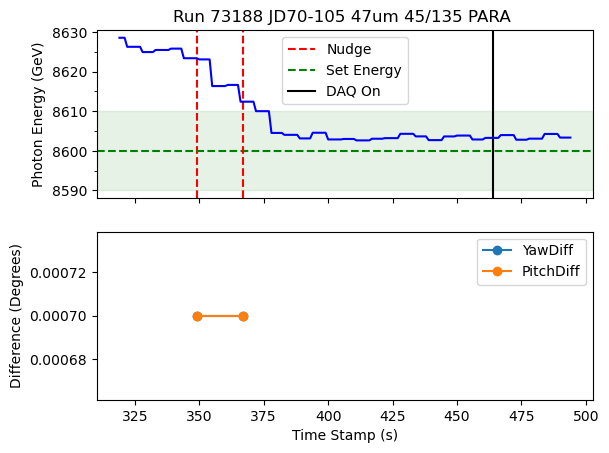

should have  [5] nudges for run 73188
energy change is 19.292500000001382
num_nudges_better is 2.0
energy change per nudge for run  73188 is 9.646250000000691
plotting for run  73214
Total number of nudges this run is  [7]
Nudge list is  [6 7]
Nudge has backlash count BacklashNudge
False    7329
True        5
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7327
True        7
Name: count, dtype: int64
Nudge number 6 occurs at time 773.0
Nudge number 7 occurs at time 788.0
daq on at time 858.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    146
Name: count, dtype: int64
roll values are GONI:ROLL
 34.5    7191
-10.5     143
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

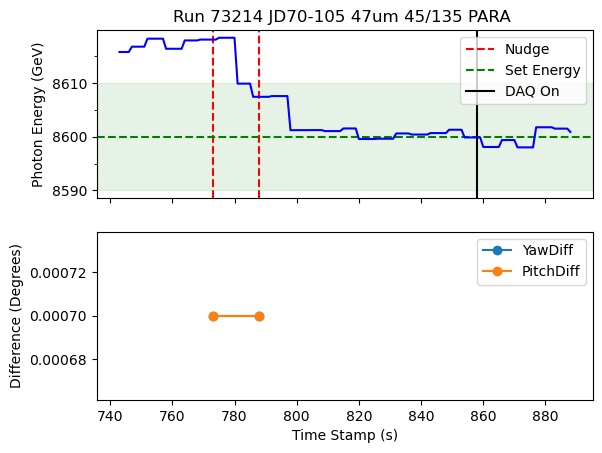

should have  [7] nudges for run 73214
energy change is 16.813333333335322
num_nudges_better is 2.0
energy change per nudge for run  73214 is 8.406666666667661
plotting for run  72105
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    6700
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6699
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 192.0
daq on at time 270.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    139
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6701
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

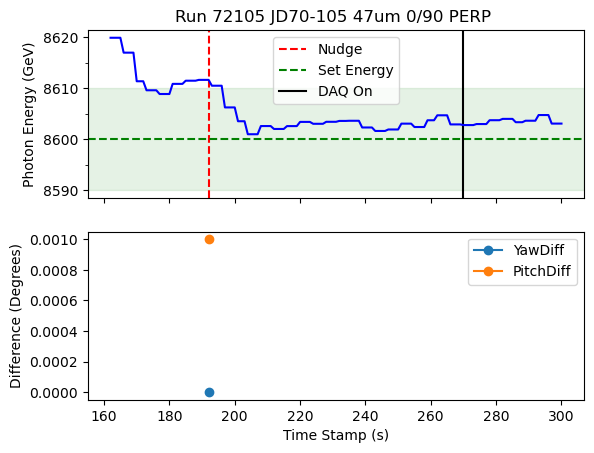

should have  [2] nudges for run 72105
energy change is 9.293999999999869
num_nudges_better is 1.0
energy change per nudge for run  72105 is 9.293999999999869
plotting for run  72142
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    6559
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6556
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 50.0
Nudge number 2 occurs at time 74.0
Nudge number 3 occurs at time 93.0
daq on at time 200.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    200
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6559
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

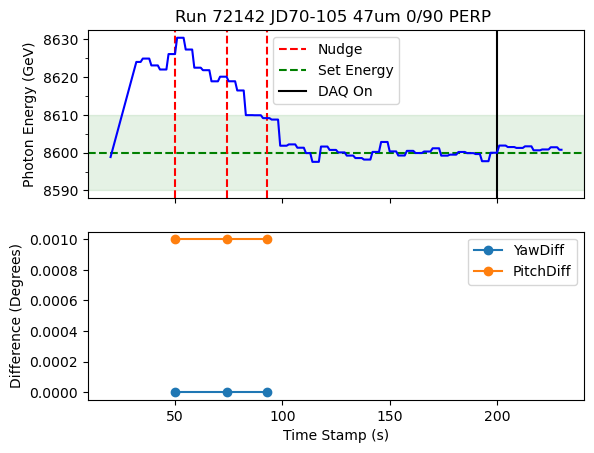

should have  [3] nudges for run 72142
energy change is 25.833999999998923
num_nudges_better is 3.0
energy change per nudge for run  72142 is 8.611333333332974
plotting for run  72158
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    7571
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7569
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 1453.0
Nudge number 3 occurs at time 1471.0
daq on at time 1591.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    193
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    7572
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

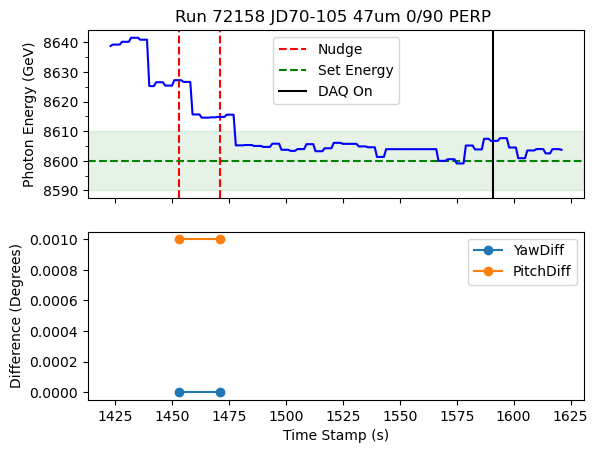

should have  [3] nudges for run 72158
energy change is 22.424999999999272
num_nudges_better is 2.0
energy change per nudge for run  72158 is 11.212499999999636
plotting for run  72173
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    6826
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6824
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 221.0
Nudge number 3 occurs at time 232.0
daq on at time 329.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    169
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6827
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

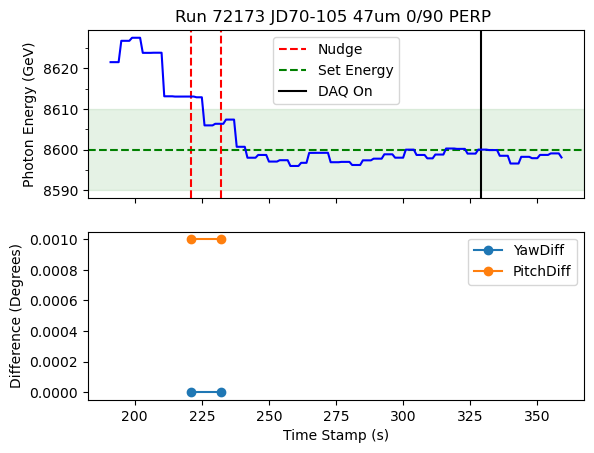

should have  [3] nudges for run 72173
energy change is 15.82799999999952
num_nudges_better is 2.0
energy change per nudge for run  72173 is 7.91399999999976
plotting for run  72190
Total number of nudges this run is  [2]
Nudge list is  [1 2]
Nudge has backlash count BacklashNudge
False    6967
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6965
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 123.0
Nudge number 2 occurs at time 134.0
daq on at time 185.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    118
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6967
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

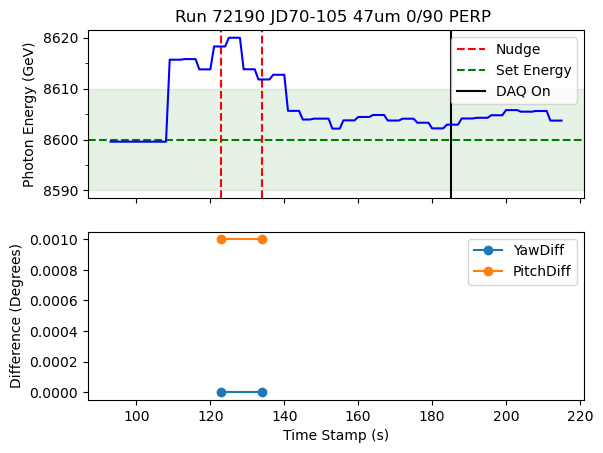

should have  [2] nudges for run 72190
energy change is 14.430000000000291
num_nudges_better is 2.0
energy change per nudge for run  72190 is 7.2150000000001455
plotting for run  72266
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    6859
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6858
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 366.0
daq on at time 344.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    83
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6860
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

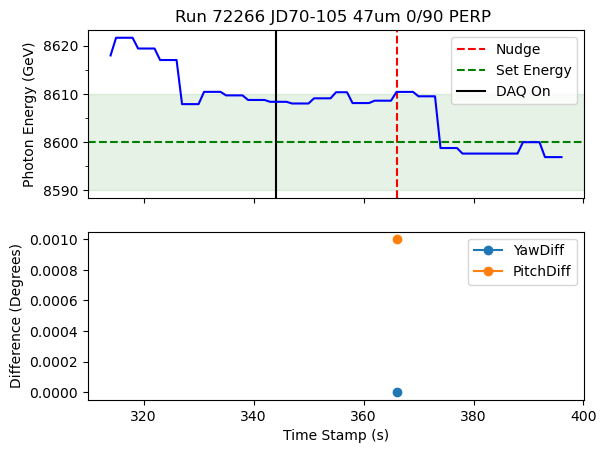

should have  [2] nudges for run 72266
energy change is 12.22666666666737
num_nudges_better is 1.0
energy change per nudge for run  72266 is 12.22666666666737
plotting for run  72285
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    7560
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7559
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 197.0
daq on at time 341.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    205
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    7561
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

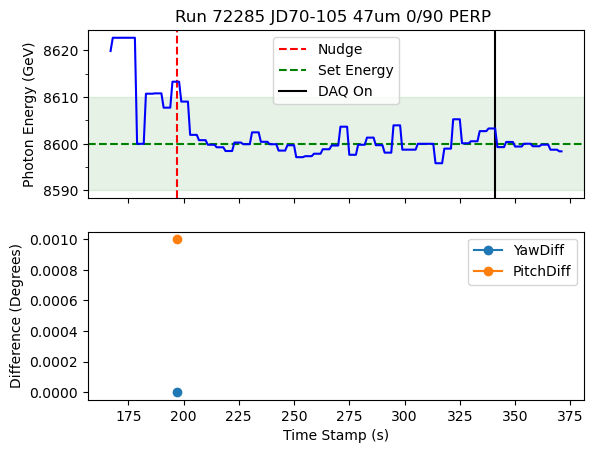

should have  [2] nudges for run 72285
energy change is 13.768000000001848
num_nudges_better is 1.0
energy change per nudge for run  72285 is 13.768000000001848
plotting for run  72367
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    9694
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    9693
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 3966.0
daq on at time 4332.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    427
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    9414
 0.0      280
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

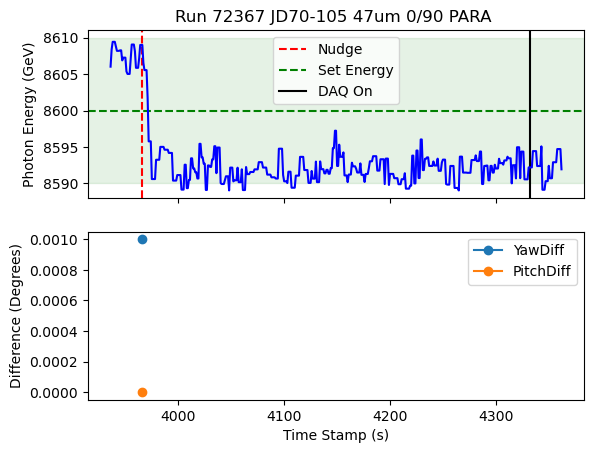

should have  [1] nudges for run 72367
energy change is 15.523999999999432
num_nudges_better is 1.0
energy change per nudge for run  72367 is 15.523999999999432
plotting for run  72406
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    6872
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6870
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 286.0
Nudge number 3 occurs at time 338.0
daq on at time 366.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    139
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6873
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

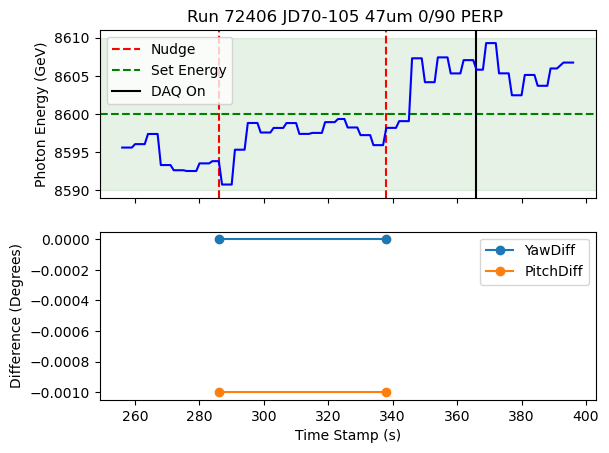

should have  [3] nudges for run 72406
energy change is 12.126000000000204
num_nudges_better is 2.0
energy change per nudge for run  72406 is 6.063000000000102
plotting for run  72434
Total number of nudges this run is  [4]
Nudge list is  [3 4]
Nudge has backlash count BacklashNudge
False    6205
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6203
True        4
Name: count, dtype: int64
Nudge number 3 occurs at time 246.0
Nudge number 4 occurs at time 260.0
daq on at time 289.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    103
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6207
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

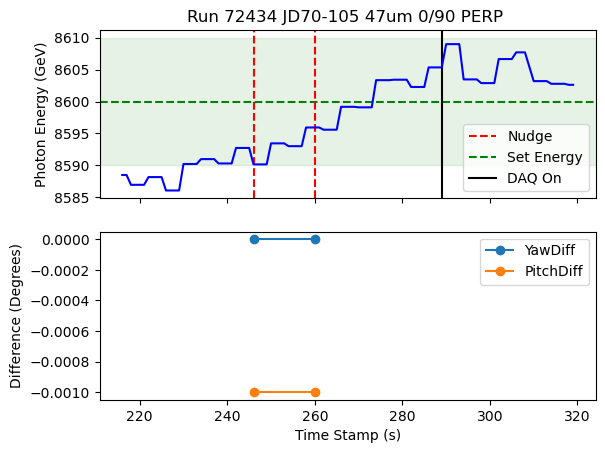

should have  [4] nudges for run 72434
energy change is 14.540000000000873
num_nudges_better is 2.0
energy change per nudge for run  72434 is 7.270000000000437
plotting for run  72650
Total number of nudges this run is  [2]
Nudge list is  [1 2]
Nudge has backlash count BacklashNudge
False    4459
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4457
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 2951.0
Nudge number 2 occurs at time 2961.0
daq on at time 642.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    1985
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    4345
 0.0      114
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

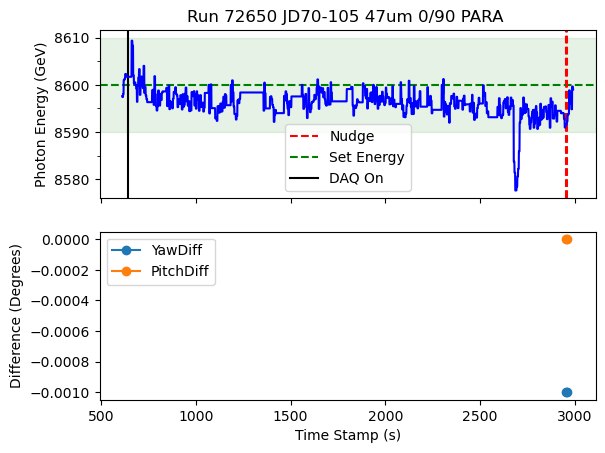

should have  [2] nudges for run 72650
energy change is 6.145999999998821
num_nudges_better is 2.0
energy change per nudge for run  72650 is 3.0729999999994106
plotting for run  72703
Total number of nudges this run is  [2]
Nudge list is  [1 2]
Nudge has backlash count BacklashNudge
False    6326
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6324
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 52.0
Nudge number 2 occurs at time 123.0
daq on at time 198.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    196
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6326
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

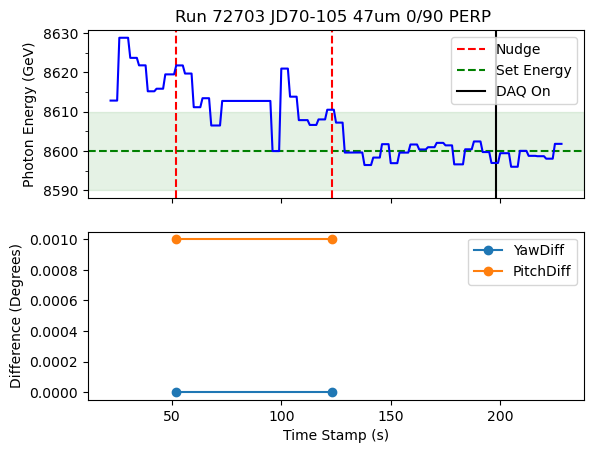

should have  [2] nudges for run 72703
energy change is 23.357500000000073
num_nudges_better is 2.0
energy change per nudge for run  72703 is 11.678750000000036
plotting for run  72707
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    3439
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3438
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 549.0
daq on at time 242.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    368
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    3439
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

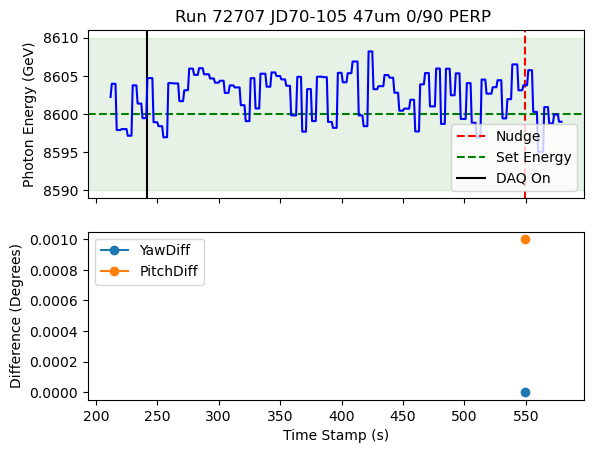

should have  [1] nudges for run 72707
energy change is 5.03400000000147
num_nudges_better is 1.0
energy change per nudge for run  72707 is 5.03400000000147
plotting for run  72725
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    667
True       1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    665
True       3
Name: count, dtype: int64
Nudge number 2 occurs at time 123.0
Nudge number 3 occurs at time 138.0
daq on at time 160.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    98
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    668
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

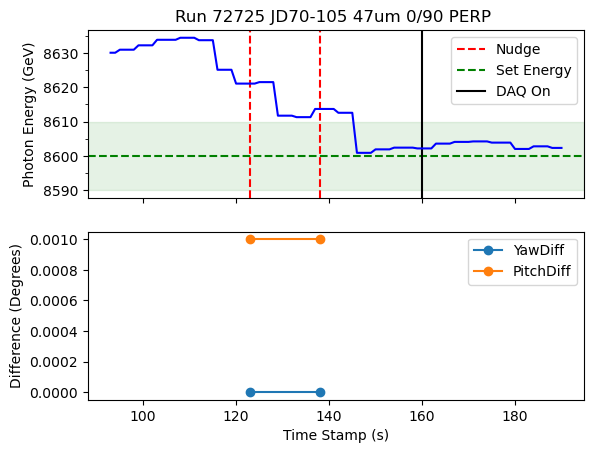

should have  [3] nudges for run 72725
energy change is 18.187999999998283
num_nudges_better is 2.0
energy change per nudge for run  72725 is 9.093999999999141
plotting for run  72739
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    3445
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3443
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 1190.0
Nudge number 3 occurs at time 1800.0
daq on at time 1857.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    462
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    3446
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

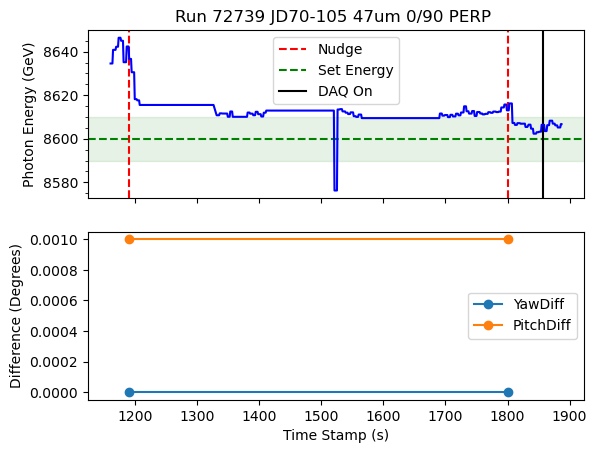

should have  [3] nudges for run 72739
energy change is 30.126000000002023
num_nudges_better is 2.0
energy change per nudge for run  72739 is 15.063000000001011
plotting for run  72749
Total number of nudges this run is  [4]
Nudge list is  [1 2 3 4]
Nudge has backlash count BacklashNudge
False    5725
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5721
True        4
Name: count, dtype: int64
Nudge number 1 occurs at time 270.0
Nudge number 2 occurs at time 271.0
Nudge number 3 occurs at time 285.0
Nudge number 4 occurs at time 302.0
daq on at time 383.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    139
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    5612
 0.0      113
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

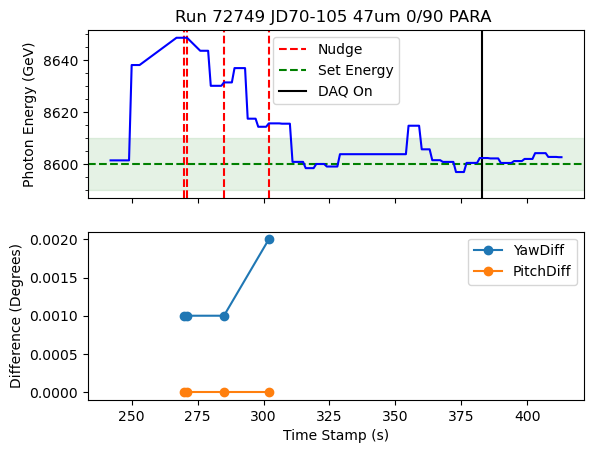

should have  [4] nudges for run 72749
energy change is 48.1200000000008
num_nudges_better is 4.0
energy change per nudge for run  72749 is 12.0300000000002
plotting for run  72780
Total number of nudges this run is  [7]
Nudge list is  [1 2 3 4 5 6]
Nudge has backlash count BacklashNudge
False    1438
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    1432
True        7
Name: count, dtype: int64
Nudge number 1 occurs at time 1347.0
Nudge number 2 occurs at time 1371.0
Nudge number 3 occurs at time 1385.0
Nudge number 4 occurs at time 1386.0
Nudge number 5 occurs at time 1404.0
Nudge number 6 occurs at time 1414.0
daq on at time 185.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    660
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    1439
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

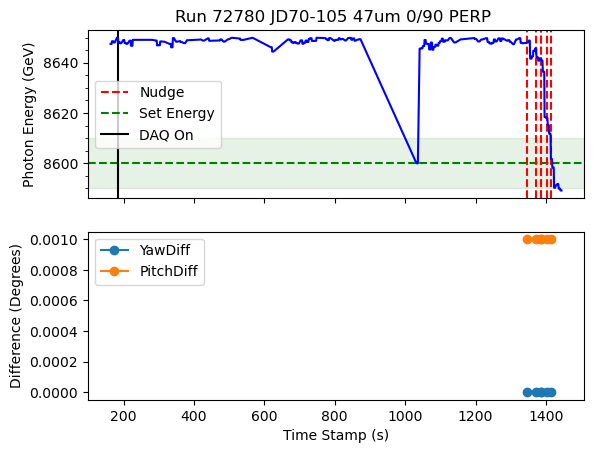

should have  [7] nudges for run 72780
energy change is 57.66749999999956
num_nudges_better is 6.0
energy change per nudge for run  72780 is 9.611249999999927
plotting for run  72781
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    4669
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4668
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 966.0
daq on at time 41.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    380
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    4669
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

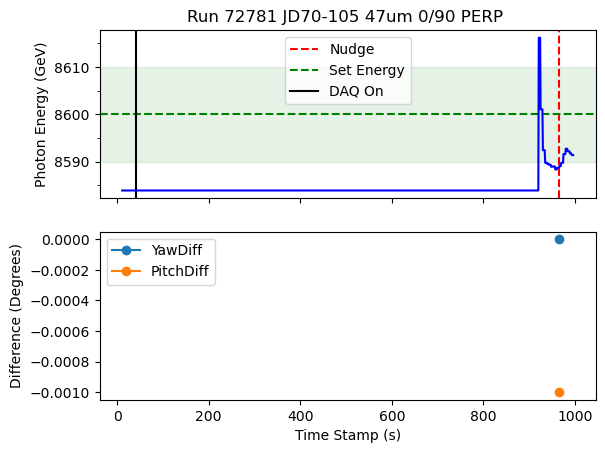

should have  [1] nudges for run 72781
energy change is 2.960000000000946
num_nudges_better is 1.0
energy change per nudge for run  72781 is 2.960000000000946
plotting for run  72796
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    6197
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6194
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 316.0
Nudge number 3 occurs at time 337.0
Nudge number 4 occurs at time 368.0
daq on at time 400.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    119
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6198
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

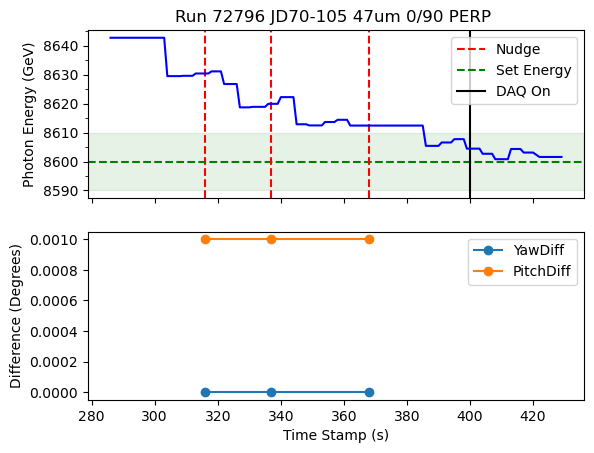

should have  [4] nudges for run 72796
energy change is 22.375
num_nudges_better is 3.0
energy change per nudge for run  72796 is 7.458333333333333
plotting for run  72837
Total number of nudges this run is  [6]
Nudge list is  [2 3 4 5]
Nudge has backlash count BacklashNudge
False    1469
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    1465
True        6
Name: count, dtype: int64
Nudge number 2 occurs at time 280.0
Nudge number 3 occurs at time 299.0
Nudge number 4 occurs at time 328.0
Nudge number 5 occurs at time 354.0
daq on at time 558.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    339
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    1471
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

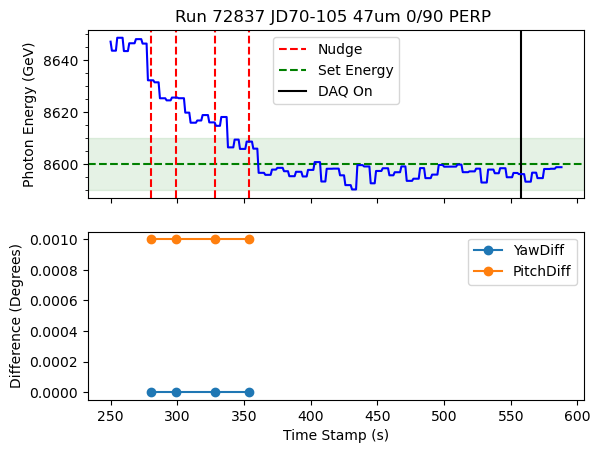

should have  [6] nudges for run 72837
energy change is 35.08800000000156
num_nudges_better is 4.0
energy change per nudge for run  72837 is 8.77200000000039
plotting for run  72848
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    6636
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6635
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 2260.0
daq on at time 1888.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    433
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6559
 0.0       78
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

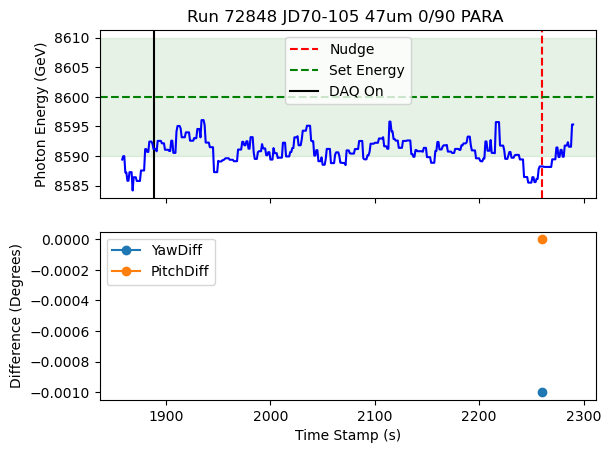

should have  [2] nudges for run 72848
energy change is 3.4087500000005093
num_nudges_better is 1.0
energy change per nudge for run  72848 is 3.4087500000005093
plotting for run  72850
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    4949
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4946
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 141.0
Nudge number 3 occurs at time 162.0
Nudge number 4 occurs at time 179.0
daq on at time 275.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    177
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    4950
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

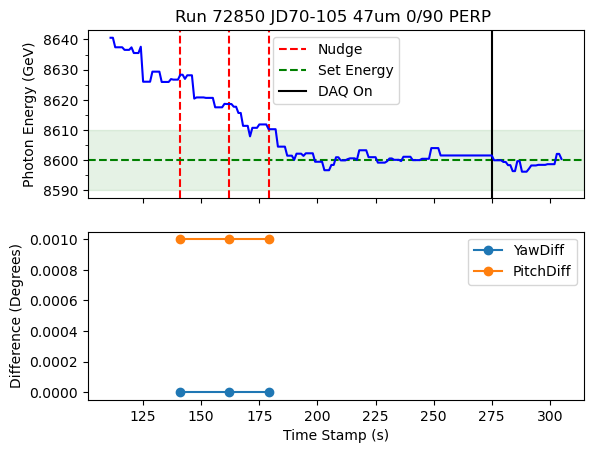

should have  [4] nudges for run 72850
energy change is 28.40333333333183
num_nudges_better is 3.0
energy change per nudge for run  72850 is 9.467777777777277
plotting for run  73058
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    6781
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6780
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 205.0
daq on at time 298.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    145
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6782
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

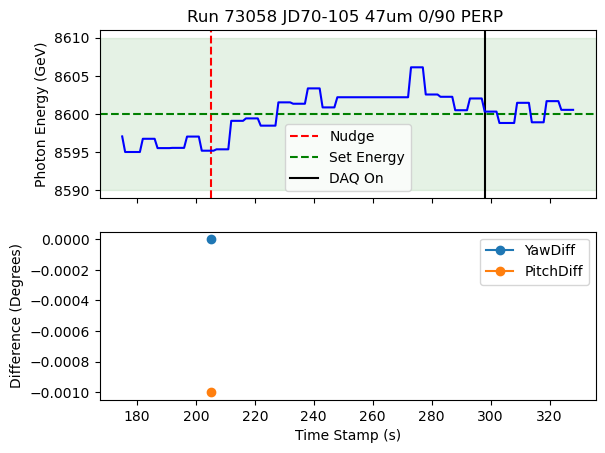

should have  [2] nudges for run 73058
energy change is 4.99750000000131
num_nudges_better is 1.0
energy change per nudge for run  73058 is 4.99750000000131
plotting for run  73160
Total number of nudges this run is  [2]
Nudge list is  [1 2]
Nudge has backlash count BacklashNudge
False    5827
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5825
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 7911.0
Nudge number 2 occurs at time 7921.0
daq on at time 7887.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    95
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    5827
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

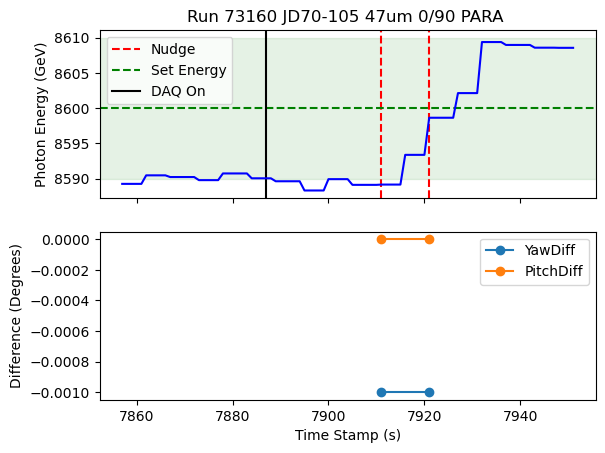

should have  [2] nudges for run 73160
energy change is 19.732500000000073
num_nudges_better is 2.0
energy change per nudge for run  73160 is 9.866250000000036
plotting for run  73184
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    6305
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6302
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 398.0
Nudge number 2 occurs at time 413.0
Nudge number 3 occurs at time 430.0
daq on at time 114.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    268
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6305
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

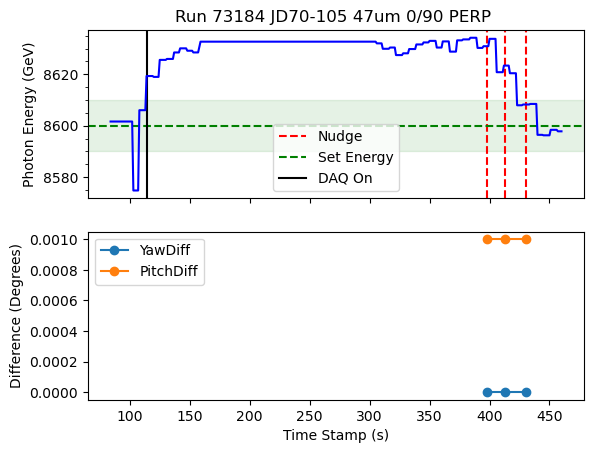

should have  [3] nudges for run 73184
energy change is 33.4333333333343
num_nudges_better is 3.0
energy change per nudge for run  73184 is 11.144444444444767


<Figure size 640x480 with 0 Axes>

In [11]:
number_nudges = []
energy_changes = []

number_nudges_0_90 = []
energy_changes_0_90 = []

number_nudges_45_135 = []
energy_changes_45_135 = []

# run lists determined by manually looking through plots of all runs, output in cell above
# only take runs where beam does not drop within 15 seconds after nudge, and where nudges are monotonic after removing backlash nudges
runs_45_135 = [72274, 72297, 72410, 72420, 72657, 72730, 72742, 72745, 72773, 72816, 73073, 73088, 73188, 73214]
runs_0_90 = [72105, 72142, 72158, 72173, 72190, 72246, 72266, 72285, 72367, 72406, 72434, 72650, 72703, 72707, 72725, 72739, 72749, 72761, 72780, 72781, 72796, 72824, 72827, 72835, 72837, 72848, 72850, 73039, 73058, 73078, 73130, 73151, 73160, 73184, 73210]
good_run_list = runs_45_135+runs_0_90

# some of the runs listed above have unreliable behavior, ie nudges that do nothing, but aren't labeled as backlash
exclude_runs = [72420, 72730, 72742, 72246, 72761, 72824, 72827, 72835, 723039, 73039, 73078, 73130, 73151, 73210]
for runNum in good_run_list:
    if runNum in exclude_runs:
        continue

    plot_run(df_2020_good,runNum)

    df_tmp = df_2020_good[(df_2020_good['RunNumber']==runNum)&(df_2020_good['NudgeOccurred'])&(~df_2020_good['BacklashNudge'])]
    df_tmp.reset_index(inplace=True)


    print('should have ',df_tmp['TotalNudges_thisRun'].unique(),'nudges for run',runNum)

    # we are looking at the subset of nudges that are not backlash, so none of these methods work for us
    #num_nudges = df_tmp['TotalNudgeSize_thisRun'].unique()[0]/0.001
    #num_nudges_alt = df_tmp['TotalNudges_thisRun'].unique()[0]
    
    # need to loop over nudge sizes, add in quadrature, and divide by 0.001
    num_nudges_fixed = 0
    for nudgeVal in df_tmp['NudgeNumber'].unique():
        df_tmp2 = df_tmp[df_tmp['NudgeNumber']==nudgeVal]
        num_nudges_fixed += (df_tmp['NudgePitchSize'].mode()[0]**2+df_tmp['NudgeYawSize'].mode()[0]**2)**0.5
    num_nudges_fixed = round(num_nudges_fixed/0.001,1)



    # look at energy at first nudge, compare to avg of last 5 energies
    nudge_list = df_tmp['NudgeNumber'].unique()
    df_first_nudge = df_tmp[df_tmp['NudgeNumber']==min(nudge_list)]
    df_first_nudge.reset_index()
    initial_energy = df_first_nudge.loc[0,'CBREM:ENERGY']


    # look 15-30 seconds after last nudge, take avg time
    df_last_nudge = df_tmp[df_tmp['NudgeNumber']==max(nudge_list)]
    df_last_nudge.reset_index(inplace=True)

    last_nudge_time = df_last_nudge.loc[0,'TimeStamp']

    df_end = df_2020_good[(df_2020_good['RunNumber']==runNum)&(df_2020_good['TimeStamp']>=(last_nudge_time+15))&(df_2020_good['TimeStamp']<=(last_nudge_time+30))]
    end_energies = df_end['CBREM:ENERGY'].unique()

    final_energy = np.mean(end_energies)

    energy_change = abs(final_energy - initial_energy)

    energy_changes.append(energy_change)
    number_nudges.append(num_nudges_fixed)

    print('energy change is',energy_change)
    print('num_nudges_better is',num_nudges_fixed)
    print('energy change per nudge for run ',runNum,'is',energy_change/num_nudges_fixed)

    if runNum in runs_45_135:
        energy_changes_45_135.append(energy_change)
        number_nudges_45_135.append(num_nudges_fixed)
    else:
        energy_changes_0_90.append(energy_change)
        number_nudges_0_90.append(num_nudges_fixed)


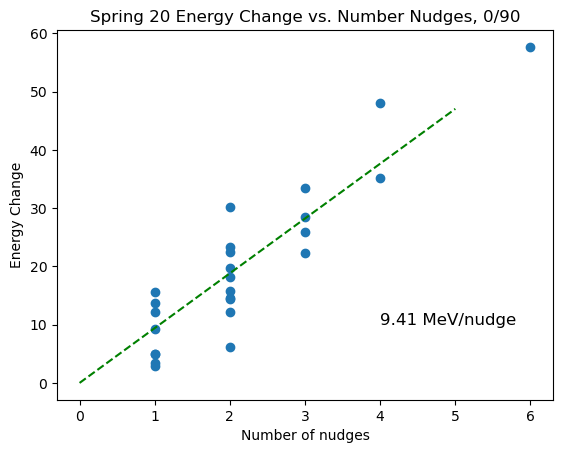

In [12]:
plt.scatter(number_nudges_0_90,energy_changes_0_90)
plt.title("Spring 20 Energy Change vs. Number Nudges, 0/90")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,50)
plt.ylabel("Energy Change")

from sklearn.linear_model import LinearRegression 
lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_0_90).reshape(-1,1)
y = energy_changes_0_90
lr.fit(X,y)

x_vals = np.array(np.arange(0,6,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_0_90_Spring20.pdf')

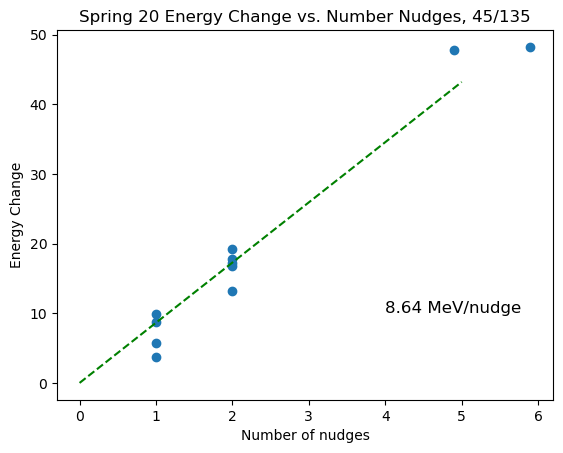

In [13]:
plt.scatter(number_nudges_45_135,energy_changes_45_135)
plt.title("Spring 20 Energy Change vs. Number Nudges, 45/135")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,30)
plt.ylabel("Energy Change")

lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_45_135).reshape(-1,1)
y = energy_changes_45_135
lr.fit(X,y)

x_vals = np.array(np.arange(0,6,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_45_135_Spring20.pdf')

In [ ]:
# now for Spring 23
# if a plot has no nudges drawn, it means all nudges were backlash
#for runVal in nudge_list_2023:
#    plot_run(df_2023_good,runVal)

In [ ]:
df_tmp = df_2023[df_2023['RunNumber']==121099]
df_tmp.to_csv("tmp.csv")

plotting for run  120784
Total number of nudges this run is  [4]
Nudge list is  [1 2 3 4]
Nudge has backlash count BacklashNudge
False    4560
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4556
True        4
Name: count, dtype: int64
Nudge number 1 occurs at time 3454.0
Nudge number 2 occurs at time 3473.0
Nudge number 3 occurs at time 3484.0
Nudge number 4 occurs at time 3497.0
daq on at time 3581.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    185
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    2706
 0.0      1854
Name: count, dtype: int64


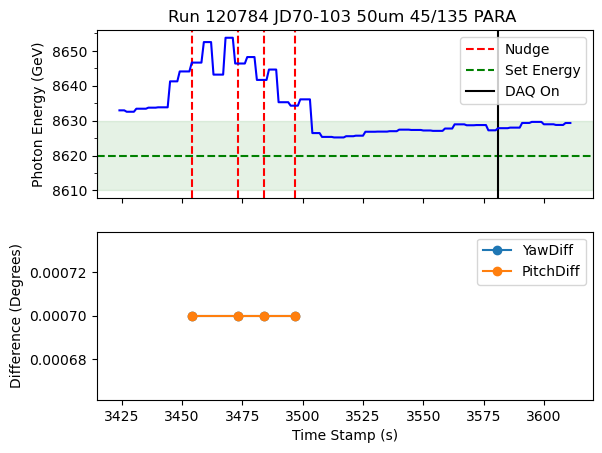

should have  [4] nudges for run 120784
energy change is 20.91399999999885
num_nudges_better is 4.0
energy change per nudge for run  120784 is 5.228499999999713
plotting for run  120828
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    5605
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5604
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 281.0
daq on at time 325.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    101
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    5550
 0.0        56
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

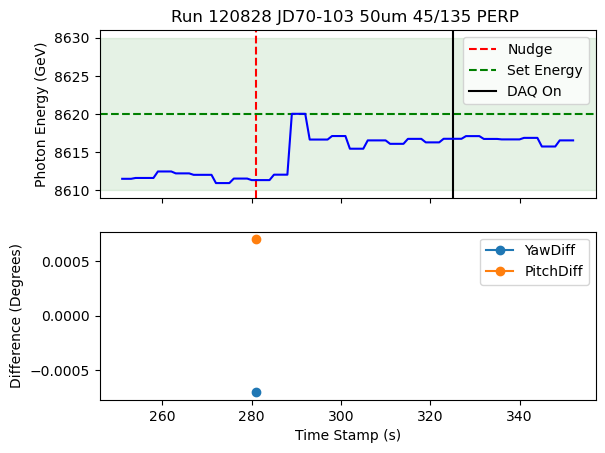

should have  [2] nudges for run 120828
energy change is 5.027999999998428
num_nudges_better is 1.0
energy change per nudge for run  120828 is 5.027999999998428
plotting for run  121099
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    5908
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5906
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 650.0
daq on at time 817.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    214
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    5791
 162.0     118
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

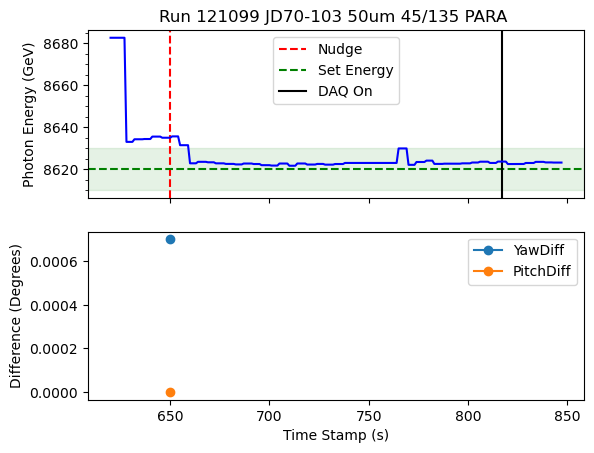

should have  [2] nudges for run 121099
energy change is 11.942500000001019
num_nudges_better is 0.0
energy change per nudge for run  121099 is inf
plotting for run  121132
Total number of nudges this run is  [7]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    3145
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3142
True        7
Name: count, dtype: int64
Nudge number 2 occurs at time 282.0
Nudge number 3 occurs at time 289.0
Nudge number 4 occurs at time 296.0
daq on at time 486.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    265
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    3149
Name: count, dtype: int64


/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57317/3707784482.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  print('energy change per nudge for run ',runNum,'is',energy_change/num_nudges_fixed)


<Figure size 640x480 with 0 Axes>

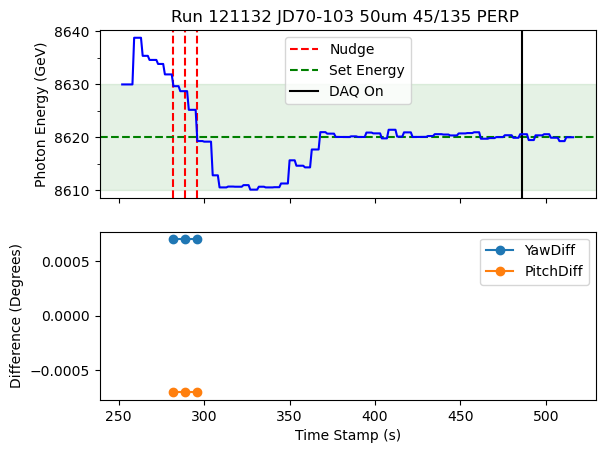

should have  [7] nudges for run 121132
energy change is 18.909999999999854
num_nudges_better is 3.0
energy change per nudge for run  121132 is 6.303333333333285
plotting for run  121174
Total number of nudges this run is  [4]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    5576
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5574
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 120.0
Nudge number 3 occurs at time 133.0
daq on at time 147.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    88
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    5578
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

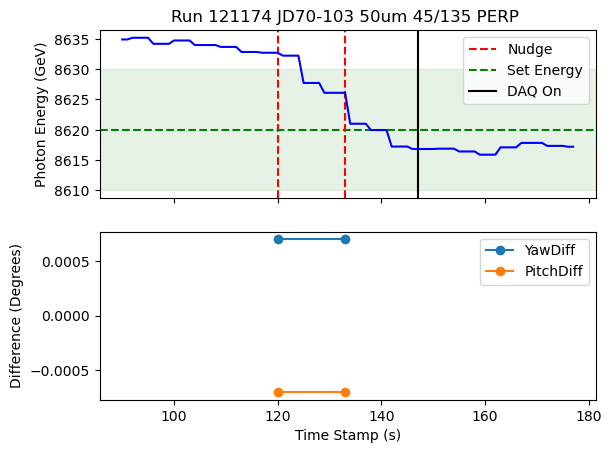

should have  [4] nudges for run 121174
energy change is 16.066000000000713
num_nudges_better is 2.0
energy change per nudge for run  121174 is 8.033000000000357
plotting for run  121187
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    5786
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5785
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 166.0
daq on at time 234.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    129
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    5787
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

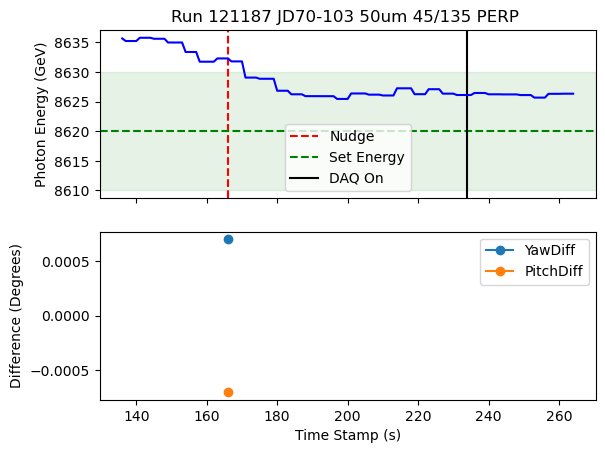

should have  [2] nudges for run 121187
energy change is 6.0575000000008
num_nudges_better is 1.0
energy change per nudge for run  121187 is 6.0575000000008
plotting for run  121205
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    941
True       1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    939
True       3
Name: count, dtype: int64
Nudge number 2 occurs at time 733.0
Nudge number 3 occurs at time 802.0
daq on at time 918.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -153.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-153.0    145
Name: count, dtype: int64
roll values are GONI:ROLL
-153.0    942
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

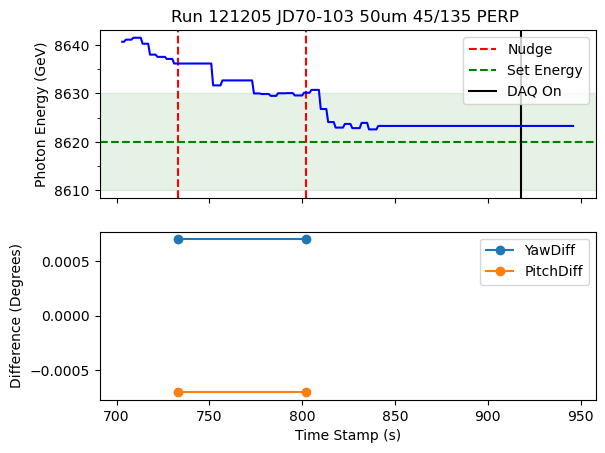

should have  [3] nudges for run 121205
energy change is 12.650000000001455
num_nudges_better is 2.0
energy change per nudge for run  121205 is 6.325000000000728
plotting for run  120420
Total number of nudges this run is  [5]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    3149
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3147
True        5
Name: count, dtype: int64
Nudge number 2 occurs at time 373.0
Nudge number 3 occurs at time 388.0
daq on at time 289.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    157
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    3152
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

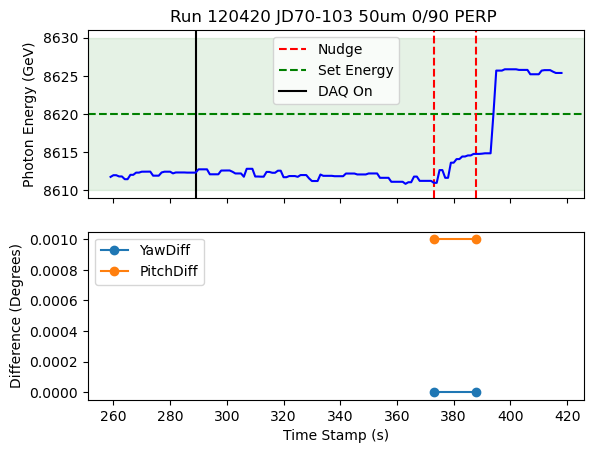

should have  [5] nudges for run 120420
energy change is 14.569999999999709
num_nudges_better is 2.0
energy change per nudge for run  120420 is 7.2849999999998545
plotting for run  120848
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    5694
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5691
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 177.0
Nudge number 3 occurs at time 197.0
Nudge number 4 occurs at time 210.0
daq on at time 286.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    169
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    5695
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

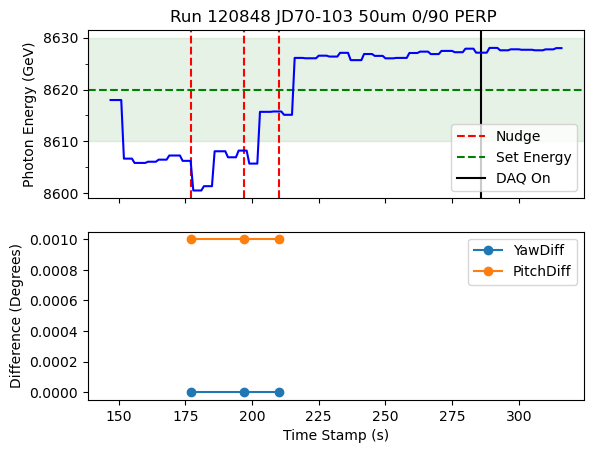

should have  [4] nudges for run 120848
energy change is 20.18000000000211
num_nudges_better is 3.0
energy change per nudge for run  120848 is 6.72666666666737
plotting for run  120857
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    3306
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3303
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 251.0
Nudge number 3 occurs at time 291.0
Nudge number 4 occurs at time 461.0
daq on at time 572.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    314
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    3307
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

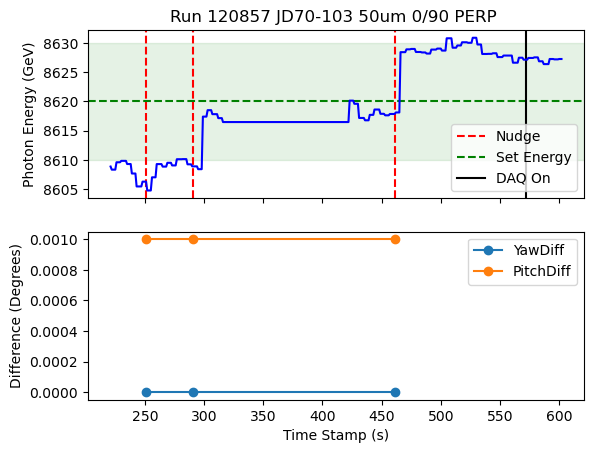

should have  [4] nudges for run 120857
energy change is 22.19250000000102
num_nudges_better is 3.0
energy change per nudge for run  120857 is 7.397500000000339
plotting for run  120894
Total number of nudges this run is  [4]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    6593
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6591
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 1539.0
Nudge number 3 occurs at time 1555.0
daq on at time 1115.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    407
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    6595
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

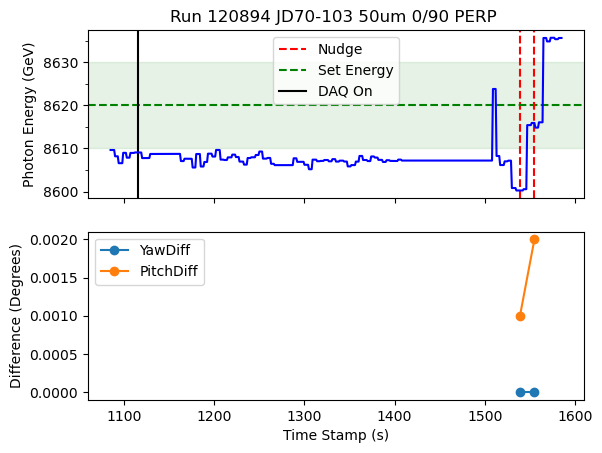

should have  [4] nudges for run 120894
energy change is 35.11249999999927
num_nudges_better is 2.0
energy change per nudge for run  120894 is 17.556249999999636
plotting for run  120931
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    2132
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2129
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 651.0
Nudge number 2 occurs at time 1160.0
Nudge number 3 occurs at time 1170.0
daq on at time 1191.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    275
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    2132
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

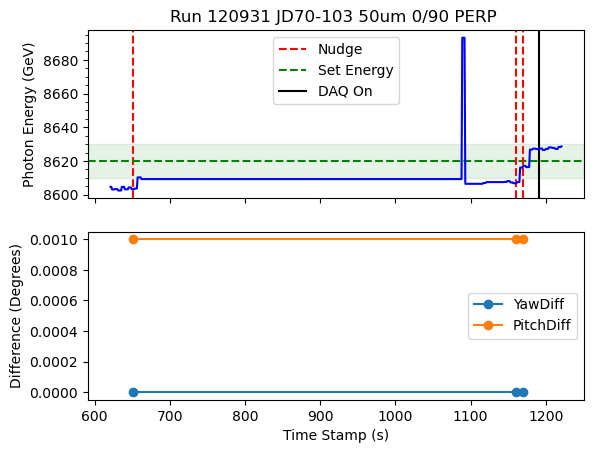

should have  [3] nudges for run 120931
energy change is 23.86200000000099
num_nudges_better is 3.0
energy change per nudge for run  120931 is 7.95400000000033
plotting for run  121036
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    2779
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2777
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 1793.0
Nudge number 3 occurs at time 1801.0
daq on at time 1648.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    214
Name: count, dtype: int64
roll values are GONI:ROLL
 162.0    2238
-153.0     542
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

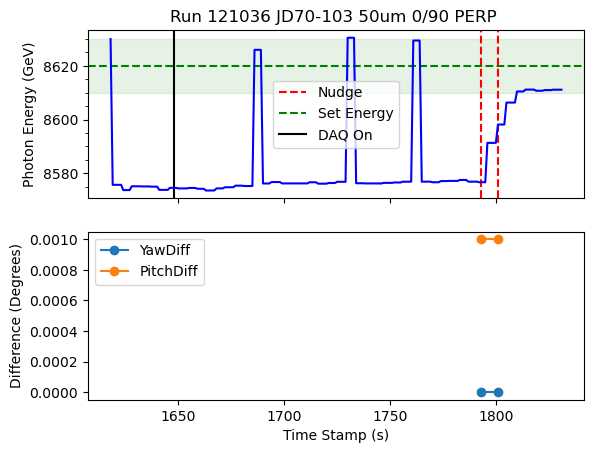

should have  [3] nudges for run 121036
energy change is 34.344999999999345
num_nudges_better is 2.0
energy change per nudge for run  121036 is 17.172499999999673
plotting for run  121051
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    5965
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5963
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 696.0
Nudge number 3 occurs at time 1448.0
daq on at time 177.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    1290
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    5966
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

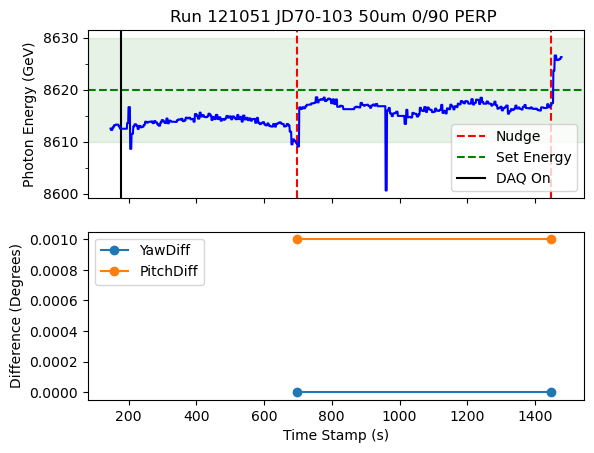

should have  [3] nudges for run 121051
energy change is 16.25250000000051
num_nudges_better is 2.0
energy change per nudge for run  121051 is 8.126250000000255
plotting for run  121068
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    6099
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6096
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 281.0
Nudge number 3 occurs at time 286.0
Nudge number 4 occurs at time 291.0
daq on at time 139.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    192
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    6100
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

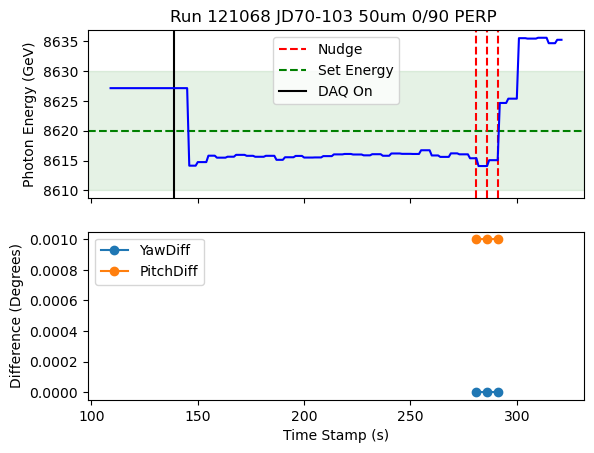

should have  [4] nudges for run 121068
energy change is 19.8125
num_nudges_better is 3.0
energy change per nudge for run  121068 is 6.604166666666667
plotting for run  121097
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    6009
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6008
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 435.0
daq on at time 467.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    93
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    6010
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

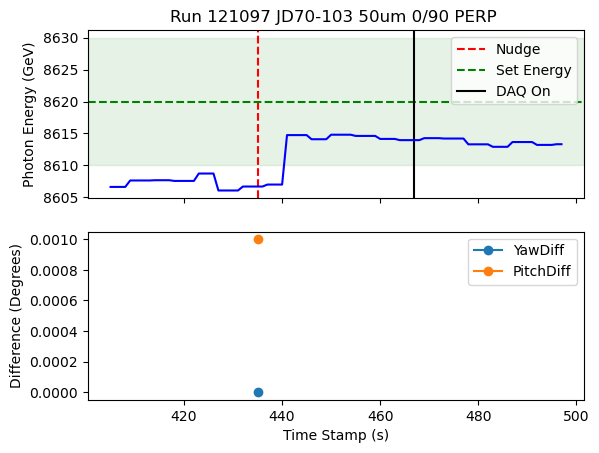

should have  [2] nudges for run 121097
energy change is 7.704999999999927
num_nudges_better is 1.0
energy change per nudge for run  121097 is 7.704999999999927
plotting for run  121183
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    6036
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6035
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 1347.0
daq on at time 543.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    852
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    6036
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

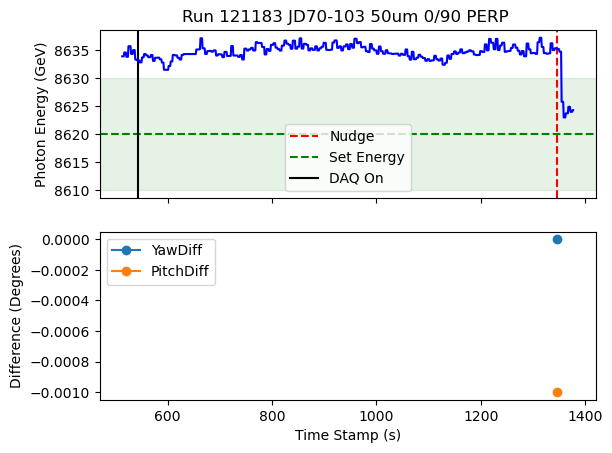

should have  [1] nudges for run 121183
energy change is 11.213999999998123
num_nudges_better is 1.0
energy change per nudge for run  121183 is 11.213999999998123


<Figure size 640x480 with 0 Axes>

In [14]:
number_nudges = []
energy_changes = []

number_nudges_0_90 = []
energy_changes_0_90 = []

number_nudges_45_135 = []
energy_changes_45_135 = []

# run lists determined by manually looking through plots of all runs, output in cell above
runs_45_135 = [120784, 120828, 121099, 121132, 121174, 121187, 121205]
runs_0_90 = [120420, 120848, 120857, 120894, 120931, 121036, 121051, 121068, 121097, 121183]
good_run_list = runs_45_135+runs_0_90

# some of the runs listed above have unreliable behavior, ie nudges that do nothing, but aren't labeled as backlash
exclude_runs = []
for runNum in good_run_list:
    if runNum in exclude_runs:
        continue

    plot_run(df_2023_good,runNum)

    df_tmp = df_2023_good[(df_2023_good['RunNumber']==runNum)&(df_2023_good['NudgeOccurred'])&(~df_2023_good['BacklashNudge'])]
    df_tmp.reset_index(inplace=True)


    print('should have ',df_tmp['TotalNudges_thisRun'].unique(),'nudges for run',runNum)

    # we are looking at the subset of nudges that are not backlash, so none of these methods work for us
    #num_nudges = df_tmp['TotalNudgeSize_thisRun'].unique()[0]/0.001
    #num_nudges_alt = df_tmp['TotalNudges_thisRun'].unique()[0]
    
    # need to loop over nudge sizes, add in quadrature, and divide by 0.001
    num_nudges_fixed = 0
    for nudgeVal in df_tmp['NudgeNumber'].unique():
        df_tmp2 = df_tmp[df_tmp['NudgeNumber']==nudgeVal]
        num_nudges_fixed += (df_tmp['NudgePitchSize'].mode()[0]**2+df_tmp['NudgeYawSize'].mode()[0]**2)**0.5
    num_nudges_fixed = round(num_nudges_fixed/0.001,1)



    # look at energy at first nudge, compare to avg of last 5 energies
    nudge_list = df_tmp['NudgeNumber'].unique()
    df_first_nudge = df_tmp[df_tmp['NudgeNumber']==min(nudge_list)]
    df_first_nudge.reset_index()
    initial_energy = df_first_nudge.loc[0,'CBREM:ENERGY']


    # look 15-30 seconds after last nudge, take avg time
    df_last_nudge = df_tmp[df_tmp['NudgeNumber']==max(nudge_list)]
    df_last_nudge.reset_index(inplace=True)

    last_nudge_time = df_last_nudge.loc[0,'TimeStamp']

    df_end = df_2023_good[(df_2023_good['RunNumber']==runNum)&(df_2023_good['TimeStamp']>=(last_nudge_time+15))&(df_2023_good['TimeStamp']<=(last_nudge_time+30))]
    end_energies = df_end['CBREM:ENERGY'].unique()

    final_energy = np.mean(end_energies)

    energy_change = abs(final_energy - initial_energy)

    energy_changes.append(energy_change)
    number_nudges.append(num_nudges_fixed)

    print('energy change is',energy_change)
    print('num_nudges_better is',num_nudges_fixed)
    print('energy change per nudge for run ',runNum,'is',energy_change/num_nudges_fixed)

    if runNum in runs_45_135:
        energy_changes_45_135.append(energy_change)
        number_nudges_45_135.append(num_nudges_fixed)
    else:
        energy_changes_0_90.append(energy_change)
        number_nudges_0_90.append(num_nudges_fixed)


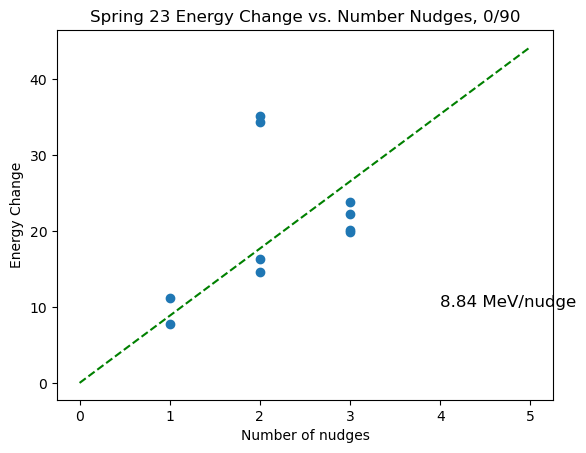

In [15]:
plt.scatter(number_nudges_0_90,energy_changes_0_90)
plt.title("Spring 23 Energy Change vs. Number Nudges, 0/90")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,50)
plt.ylabel("Energy Change")

from sklearn.linear_model import LinearRegression 
lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_0_90).reshape(-1,1)
y = energy_changes_0_90
lr.fit(X,y)

x_vals = np.array(np.arange(0,6,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_0_90_Spring23.pdf')

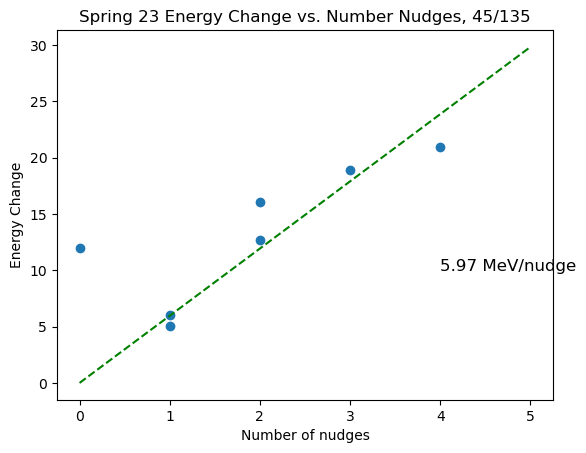

In [16]:
plt.scatter(number_nudges_45_135,energy_changes_45_135)
plt.title("Spring 23 Energy Change vs. Number Nudges, 45/135")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,30)
plt.ylabel("Energy Change")

lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_45_135).reshape(-1,1)
y = energy_changes_45_135
lr.fit(X,y)

x_vals = np.array(np.arange(0,6,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_45_135_Spring23.pdf')

In [17]:
# now for Spring 25
# if a plot has no nudges drawn, it means all nudges were backlash
#for runVal in nudge_list_2025:
#    plot_run(df_2025_good,runVal)

plotting for run  131409
Total number of nudges this run is  [12]
Nudge list is  [ 5  6  7  8  9 10 11]
Nudge has backlash count BacklashNudge
False    1385
True        5
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    1378
True       12
Name: count, dtype: int64
Nudge number 5 occurs at time 200.0
Nudge number 6 occurs at time 206.0
Nudge number 7 occurs at time 212.0
Nudge number 8 occurs at time 226.0
Nudge number 9 occurs at time 234.0
Nudge number 10 occurs at time 243.0
Nudge number 11 occurs at time 268.0
daq on at time 521.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    355
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    1390
Name: count, dtype: int64


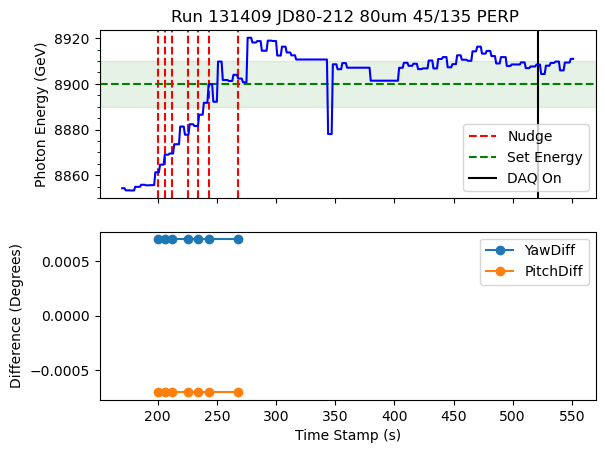

should have  [12] nudges for run 131409
energy change is 56.58399999999892
num_nudges_better is 6.9
energy change per nudge for run  131409 is 8.20057971014477
plotting for run  131662
Total number of nudges this run is  [6]
Nudge list is  [4 5 6]
Nudge has backlash count BacklashNudge
False    4347
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4344
True        6
Name: count, dtype: int64
Nudge number 4 occurs at time 970.0
Nudge number 5 occurs at time 972.0
Nudge number 6 occurs at time 973.0
daq on at time 585.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    398
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    4350
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

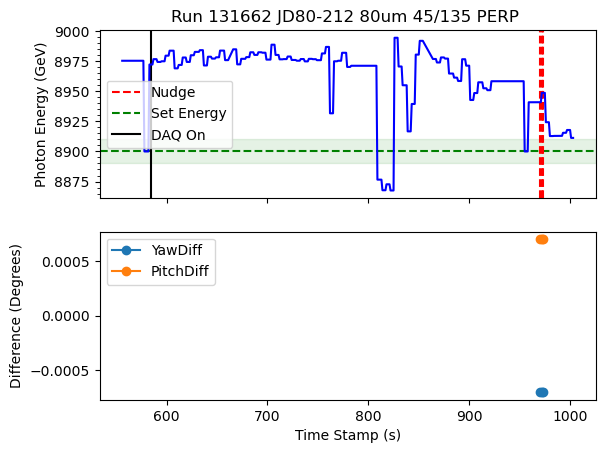

should have  [6] nudges for run 131662
energy change is 26.51749999999811
num_nudges_better is 3.0
energy change per nudge for run  131662 is 8.839166666666037
plotting for run  131703
Total number of nudges this run is  [8]
Nudge list is  [2 3 4 5 6 7 8]
Nudge has backlash count BacklashNudge
False    6204
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6197
True        8
Name: count, dtype: int64
Nudge number 2 occurs at time 4226.0
Nudge number 3 occurs at time 4228.0
Nudge number 4 occurs at time 4229.0
Nudge number 5 occurs at time 4232.0
Nudge number 6 occurs at time 4234.0
Nudge number 7 occurs at time 4236.0
Nudge number 8 occurs at time 4239.0
daq on at time 4302.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    137
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    6205
Name: count, dtype: int6

<Figure size 640x480 with 0 Axes>

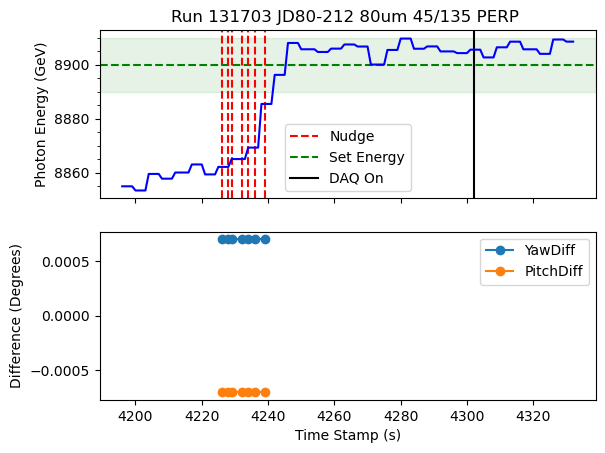

should have  [8] nudges for run 131703
energy change is 44.01800000000003
num_nudges_better is 6.9
energy change per nudge for run  131703 is 6.3794202898550765
plotting for run  131714
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    6295
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6292
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 269.0
Nudge number 3 occurs at time 293.0
Nudge number 4 occurs at time 294.0
daq on at time 416.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    208
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    6296
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

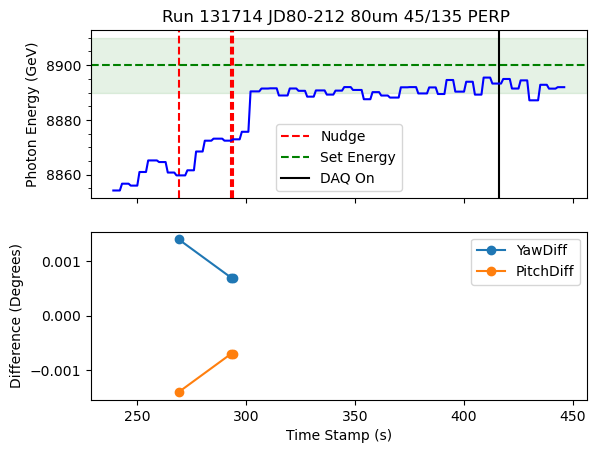

should have  [4] nudges for run 131714
energy change is 31.058000000000902
num_nudges_better is 3.0
energy change per nudge for run  131714 is 10.352666666666968
plotting for run  131734
Total number of nudges this run is  [7]
Nudge list is  [4 5 6 7]
Nudge has backlash count BacklashNudge
False    7526
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7522
True        7
Name: count, dtype: int64
Nudge number 4 occurs at time 1073.0
Nudge number 5 occurs at time 1090.0
Nudge number 6 occurs at time 1098.0
Nudge number 7 occurs at time 1114.0
daq on at time 394.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    776
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    7529
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

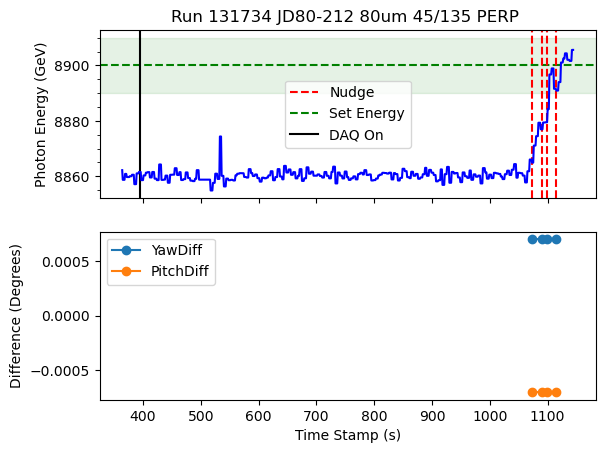

should have  [7] nudges for run 131734
energy change is 38.314000000000306
num_nudges_better is 4.0
energy change per nudge for run  131734 is 9.578500000000076
plotting for run  131777
Total number of nudges this run is  [4]
Nudge list is  [4]
Nudge has backlash count BacklashNudge
False    2486
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2485
True        4
Name: count, dtype: int64
Nudge number 4 occurs at time 319.0
daq on at time 357.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    99
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    2489
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

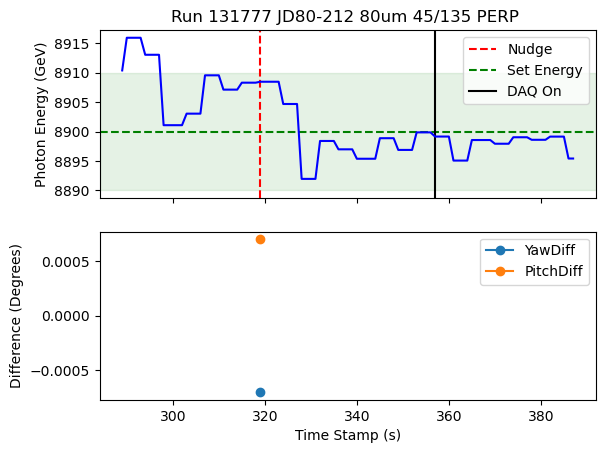

should have  [4] nudges for run 131777
energy change is 11.157999999999447
num_nudges_better is 1.0
energy change per nudge for run  131777 is 11.157999999999447
plotting for run  131807
Total number of nudges this run is  [6]
Nudge list is  [2 3 4 5 6]
Nudge has backlash count BacklashNudge
False    6812
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6807
True        6
Name: count, dtype: int64
Nudge number 2 occurs at time 227.0
Nudge number 3 occurs at time 249.0
Nudge number 4 occurs at time 259.0
Nudge number 5 occurs at time 280.0
Nudge number 6 occurs at time 300.0
daq on at time 133.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    189
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    6813
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

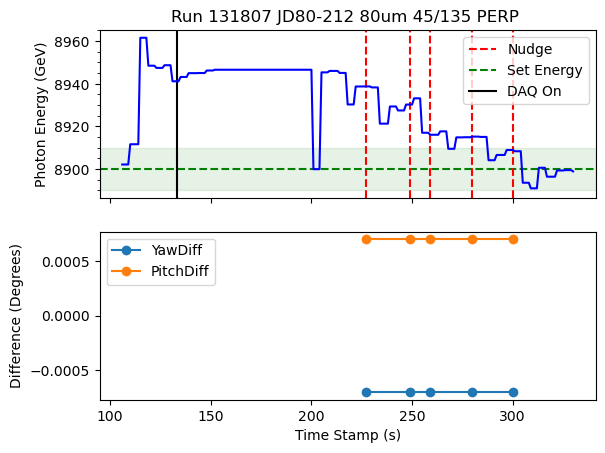

should have  [6] nudges for run 131807
energy change is 39.7920000000031
num_nudges_better is 4.9
energy change per nudge for run  131807 is 8.120816326531244
plotting for run  131825
Total number of nudges this run is  [10]
Nudge list is  [ 5  6  7  8  9 10]
Nudge has backlash count BacklashNudge
False    2569
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2563
True       10
Name: count, dtype: int64
Nudge number 5 occurs at time 235.0
Nudge number 6 occurs at time 249.0
Nudge number 7 occurs at time 257.0
Nudge number 8 occurs at time 265.0
Nudge number 9 occurs at time 283.0
Nudge number 10 occurs at time 334.0
daq on at time 470.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    285
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    2573
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

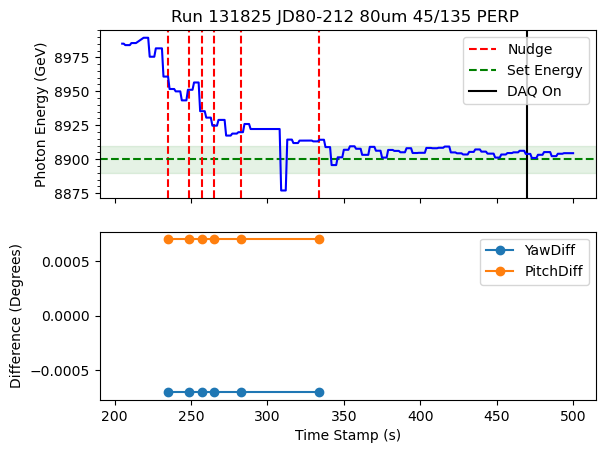

should have  [10] nudges for run 131825
energy change is 55.074000000000524
num_nudges_better is 5.9
energy change per nudge for run  131825 is 9.33457627118653
plotting for run  131863
Total number of nudges this run is  [5]
Nudge list is  [2 3 4 5]
Nudge has backlash count BacklashNudge
False    3411
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3406
True        6
Name: count, dtype: int64
Nudge number 2 occurs at time 165.0
Nudge number 3 occurs at time 183.0
Nudge number 4 occurs at time 223.0
Nudge number 5 occurs at time 247.0
daq on at time 418.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    314
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    3412
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

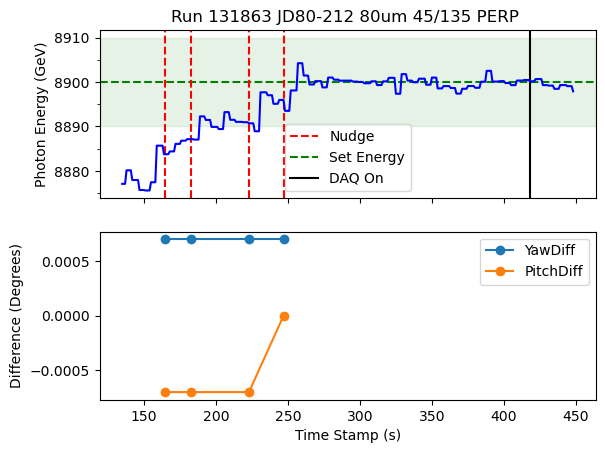

should have  [5] nudges for run 131863
energy change is 16.25249999999869
num_nudges_better is 4.0
energy change per nudge for run  131863 is 4.063124999999673
plotting for run  131866
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    690
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    689
True       1
Name: count, dtype: int64
Nudge number 1 occurs at time 689.0
daq on at time 44.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    645
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    690
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

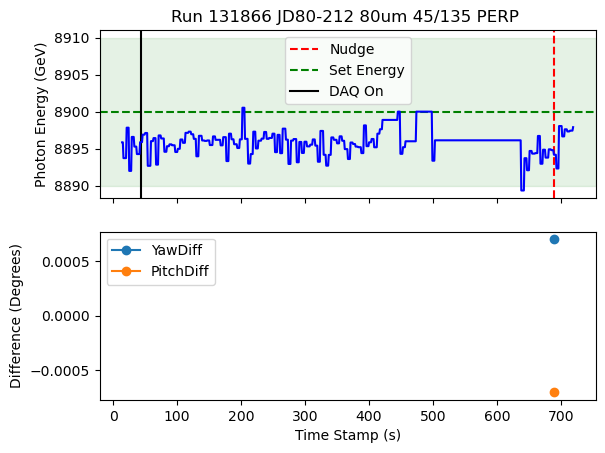

should have  [1] nudges for run 131866
energy change is 3.2120000000013533
num_nudges_better is 1.0
energy change per nudge for run  131866 is 3.2120000000013533
plotting for run  131918
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    501
True       1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    498
True       4
Name: count, dtype: int64
Nudge number 2 occurs at time 159.0
Nudge number 3 occurs at time 178.0
Nudge number 4 occurs at time 207.0
daq on at time 285.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    187
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    502
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

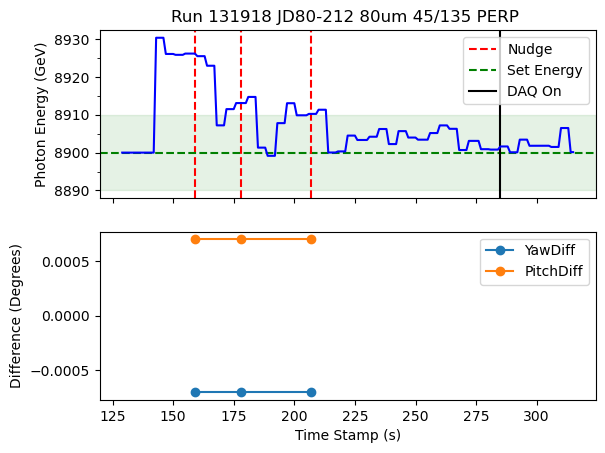

should have  [4] nudges for run 131918
energy change is 21.590000000000146
num_nudges_better is 3.0
energy change per nudge for run  131918 is 7.196666666666715
plotting for run  131932
Total number of nudges this run is  [9]
Nudge list is  [5 6 7 8]
Nudge has backlash count BacklashNudge
False    7353
True        5
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7349
True        9
Name: count, dtype: int64
Nudge number 5 occurs at time 218.0
Nudge number 6 occurs at time 236.0
Nudge number 7 occurs at time 258.0
Nudge number 8 occurs at time 280.0
daq on at time 333.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    176
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    7358
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

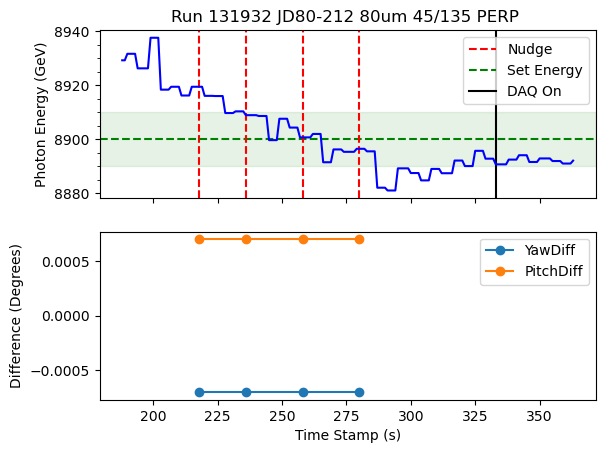

should have  [9] nudges for run 131932
energy change is 31.8224999999984
num_nudges_better is 4.0
energy change per nudge for run  131932 is 7.9556249999996
plotting for run  132033
Total number of nudges this run is  [11]
Nudge list is  [ 5  6  7  8  9 10 11]
Nudge has backlash count BacklashNudge
False    6053
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6045
True       12
Name: count, dtype: int64
Nudge number 5 occurs at time 277.0
Nudge number 6 occurs at time 282.0
Nudge number 7 occurs at time 286.0
Nudge number 8 occurs at time 294.0
Nudge number 9 occurs at time 303.0
Nudge number 10 occurs at time 327.0
Nudge number 11 occurs at time 388.0
daq on at time 751.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    535
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    6057
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

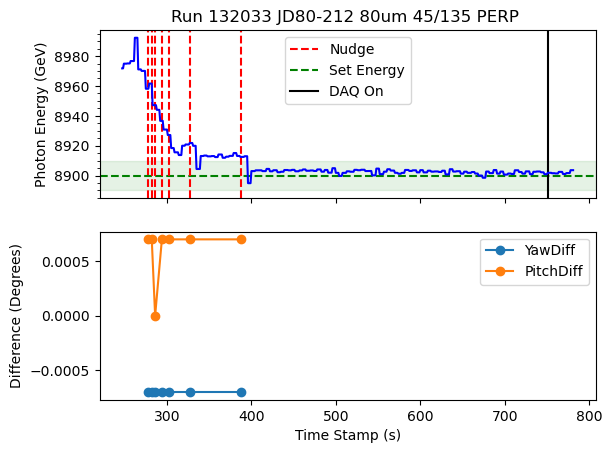

should have  [11] nudges for run 132033
energy change is 54.65599999999904
num_nudges_better is 6.9
energy change per nudge for run  132033 is 7.921159420289715
plotting for run  132061
Total number of nudges this run is  [5]
Nudge list is  [5]
Nudge has backlash count BacklashNudge
False    5983
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5982
True        5
Name: count, dtype: int64
Nudge number 5 occurs at time 1570.0
daq on at time 628.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    992
Name: count, dtype: int64
roll values are GONI:ROLL
28.4    5987
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

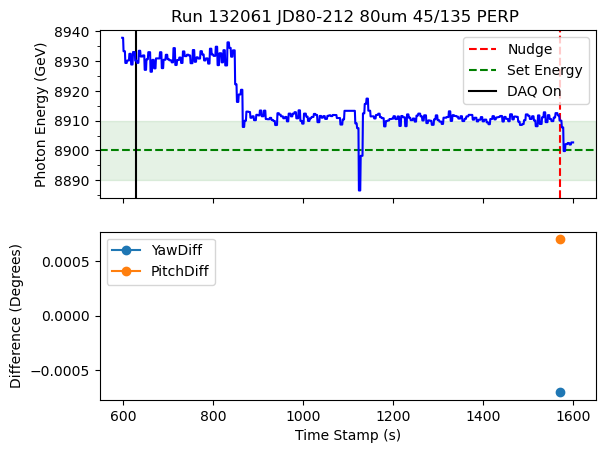

should have  [5] nudges for run 132061
energy change is 7.697500000000218
num_nudges_better is 1.0
energy change per nudge for run  132061 is 7.697500000000218
plotting for run  132071
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    7065
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7063
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 529.0
Nudge number 3 occurs at time 536.0
daq on at time 577.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
28.4    109
Name: count, dtype: int64
roll values are GONI:ROLL
 28.4    6964
-16.6     102
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

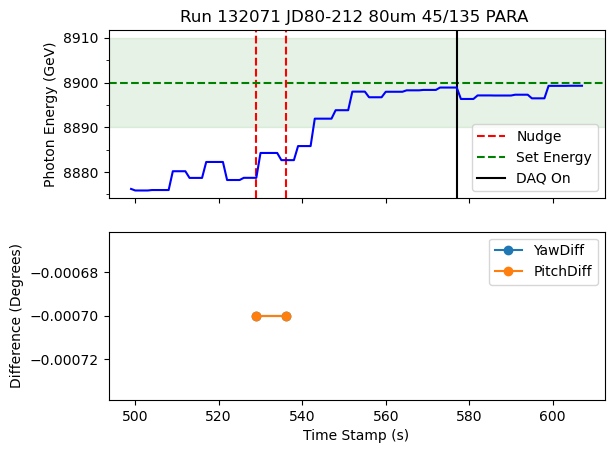

should have  [3] nudges for run 132071
energy change is 18.220000000001164
num_nudges_better is 2.0
energy change per nudge for run  132071 is 9.110000000000582
plotting for run  131421
Total number of nudges this run is  [6]
Nudge list is  [1 2 3 4 5 6]
Nudge has backlash count BacklashNudge
False    6023
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6017
True        6
Name: count, dtype: int64
Nudge number 1 occurs at time 2165.0
Nudge number 2 occurs at time 2328.0
Nudge number 3 occurs at time 2374.0
Nudge number 4 occurs at time 2389.0
Nudge number 5 occurs at time 2406.0
Nudge number 6 occurs at time 2425.0
daq on at time 777.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    1514
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    6023
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

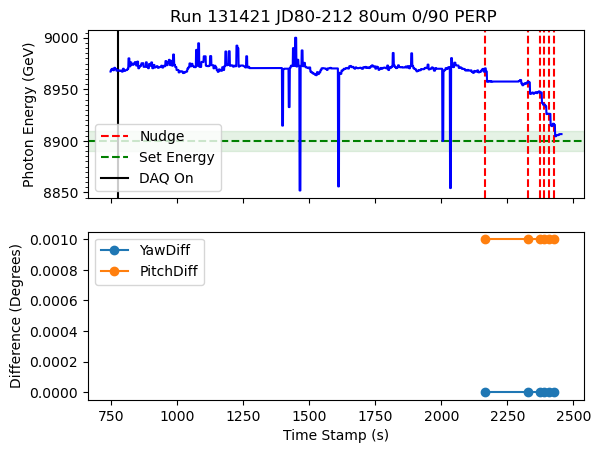

should have  [6] nudges for run 131421
energy change is 64.22999999999956
num_nudges_better is 6.0
energy change per nudge for run  131421 is 10.704999999999927
plotting for run  131602
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    2738
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2737
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 2449.0
daq on at time 890.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    1408
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    2739
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

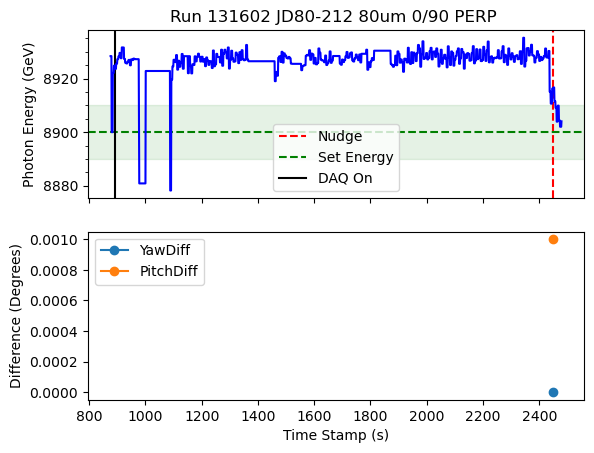

should have  [2] nudges for run 131602
energy change is 11.416000000001077
num_nudges_better is 1.0
energy change per nudge for run  131602 is 11.416000000001077
plotting for run  131634
Total number of nudges this run is  [8]
Nudge list is  [2 3 4 5 6 7]
Nudge has backlash count BacklashNudge
False    7005
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6999
True        8
Name: count, dtype: int64
Nudge number 2 occurs at time 289.0
Nudge number 3 occurs at time 309.0
Nudge number 4 occurs at time 312.0
Nudge number 5 occurs at time 326.0
Nudge number 6 occurs at time 346.0
Nudge number 7 occurs at time 347.0
daq on at time 459.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    200
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    7007
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

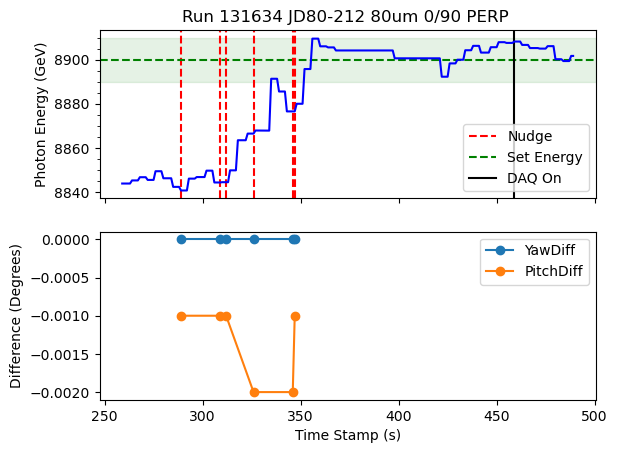

should have  [8] nudges for run 131634
energy change is 64.71000000000095
num_nudges_better is 6.0
energy change per nudge for run  131634 is 10.785000000000158
plotting for run  131677
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    6129
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6126
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 59.0
Nudge number 2 occurs at time 72.0
Nudge number 3 occurs at time 73.0
daq on at time 261.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    242
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    6129
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

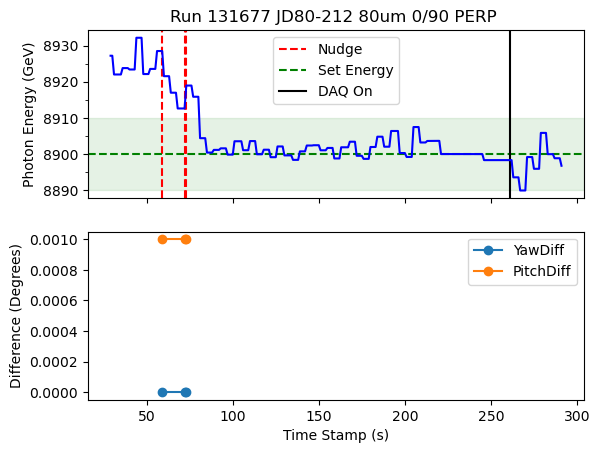

should have  [3] nudges for run 131677
energy change is 27.195999999998094
num_nudges_better is 3.0
energy change per nudge for run  131677 is 9.065333333332697
plotting for run  131771
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    3010
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3009
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 370.0
daq on at time 991.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    682
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    3011
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

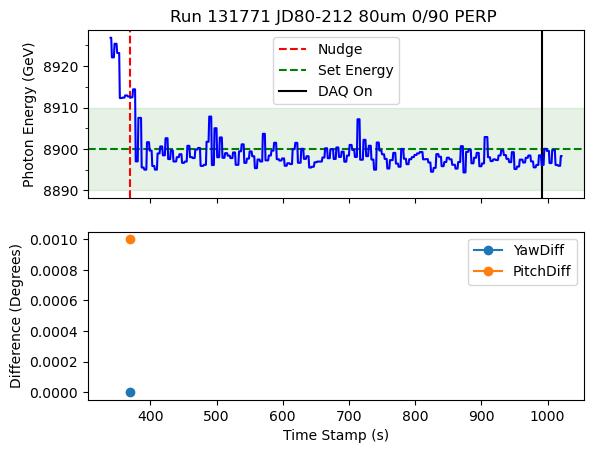

should have  [2] nudges for run 131771
energy change is 12.605999999999767
num_nudges_better is 1.0
energy change per nudge for run  131771 is 12.605999999999767
plotting for run  131801
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    4912
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4911
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 229.0
daq on at time 266.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    98
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    4913
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

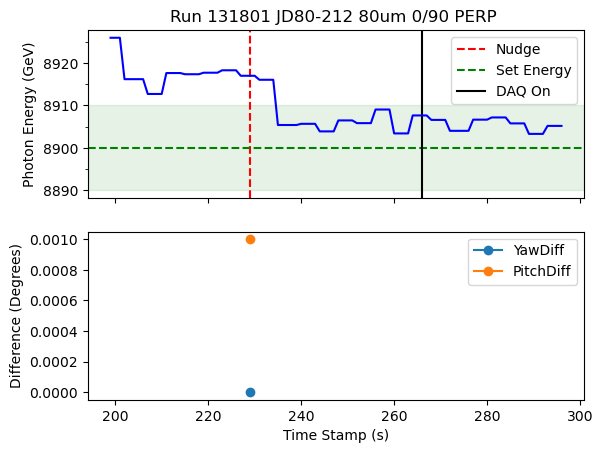

should have  [2] nudges for run 131801
energy change is 10.665000000000873
num_nudges_better is 1.0
energy change per nudge for run  131801 is 10.665000000000873
plotting for run  131874
Total number of nudges this run is  [2]
Nudge list is  [2]
Nudge has backlash count BacklashNudge
False    2634
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    2633
True        2
Name: count, dtype: int64
Nudge number 2 occurs at time 343.0
daq on at time 391.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    109
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    2506
 0.0      129
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

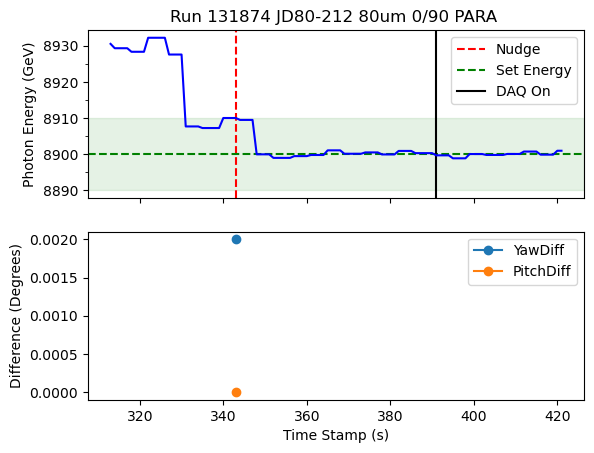

should have  [2] nudges for run 131874
energy change is 9.882499999999709
num_nudges_better is 2.0
energy change per nudge for run  131874 is 4.9412499999998545
plotting for run  131891
Total number of nudges this run is  [1]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    7635
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7634
True        1
Name: count, dtype: int64
Nudge number 1 occurs at time 7577.0
daq on at time 143.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    7399
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    7635
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

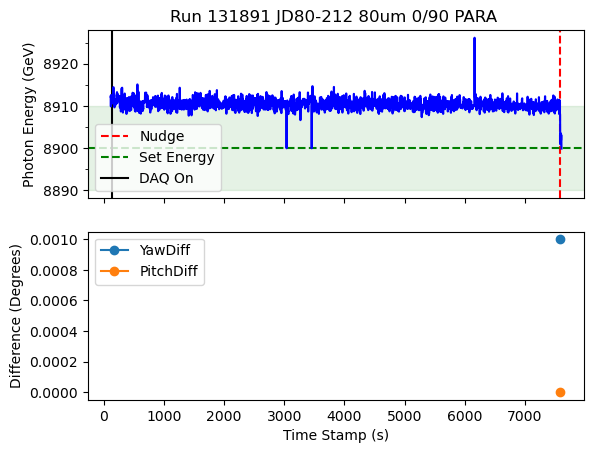

should have  [1] nudges for run 131891
energy change is 9.46600000000035
num_nudges_better is 1.0
energy change per nudge for run  131891 is 9.46600000000035
plotting for run  131908
Total number of nudges this run is  [4]
Nudge list is  [2 3 4]
Nudge has backlash count BacklashNudge
False    3536
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3533
True        4
Name: count, dtype: int64
Nudge number 2 occurs at time 672.0
Nudge number 3 occurs at time 698.0
Nudge number 4 occurs at time 729.0
daq on at time 848.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    202
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    3316
 0.0      221
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

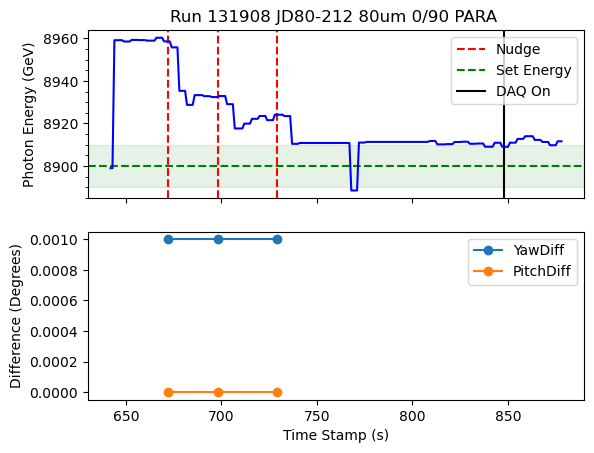

should have  [4] nudges for run 131908
energy change is 47.659999999999854
num_nudges_better is 3.0
energy change per nudge for run  131908 is 15.886666666666619
plotting for run  131925
Total number of nudges this run is  [5]
Nudge list is  [2 3 4 5]
Nudge has backlash count BacklashNudge
False    5647
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5643
True        5
Name: count, dtype: int64
Nudge number 2 occurs at time 1700.0
Nudge number 3 occurs at time 1701.0
Nudge number 4 occurs at time 1702.0
Nudge number 5 occurs at time 1703.0
daq on at time 1614.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    108
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5505
 0.0      143
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

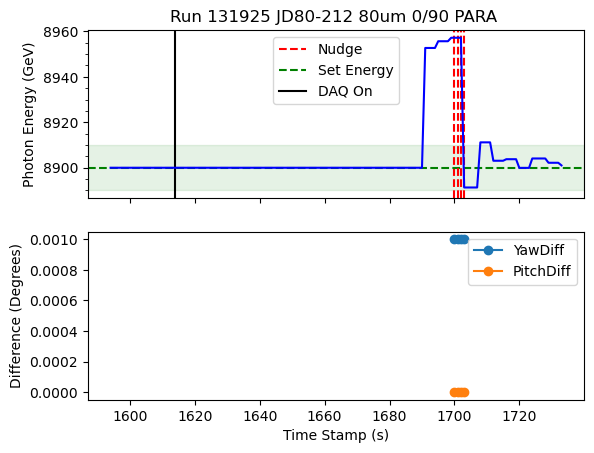

should have  [5] nudges for run 131925
energy change is 54.977999999999156
num_nudges_better is 4.0
energy change per nudge for run  131925 is 13.744499999999789
plotting for run  132009
Total number of nudges this run is  [12]
Nudge list is  [ 5  6  7  8  9 10 11 12]
Nudge has backlash count BacklashNudge
False    3208
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3200
True       12
Name: count, dtype: int64
Nudge number 5 occurs at time 419.0
Nudge number 6 occurs at time 430.0
Nudge number 7 occurs at time 442.0
Nudge number 8 occurs at time 483.0
Nudge number 9 occurs at time 498.0
Nudge number 10 occurs at time 511.0
Nudge number 11 occurs at time 525.0
Nudge number 12 occurs at time 554.0
daq on at time 139.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    453
Name: count, dtype: int64
roll values are GO

<Figure size 640x480 with 0 Axes>

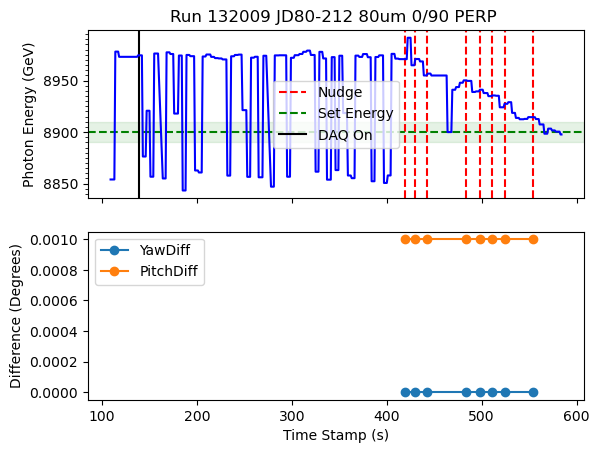

should have  [12] nudges for run 132009
energy change is 70.42599999999948
num_nudges_better is 8.0
energy change per nudge for run  132009 is 8.803249999999935
plotting for run  132024
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    7301
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7299
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 481.0
Nudge number 3 occurs at time 509.0
daq on at time 634.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    214
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    7302
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

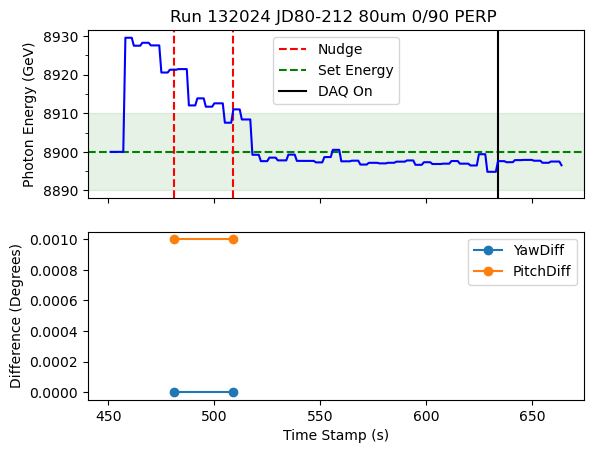

should have  [3] nudges for run 132024
energy change is 23.116000000001804
num_nudges_better is 2.0
energy change per nudge for run  132024 is 11.558000000000902
plotting for run  132048
Total number of nudges this run is  [4]
Nudge list is  [1 2 3 4]
Nudge has backlash count BacklashNudge
False    6535
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6531
True        4
Name: count, dtype: int64
Nudge number 1 occurs at time 178.0
Nudge number 2 occurs at time 182.0
Nudge number 3 occurs at time 204.0
Nudge number 4 occurs at time 230.0
daq on at time 0.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    217
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    6535
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

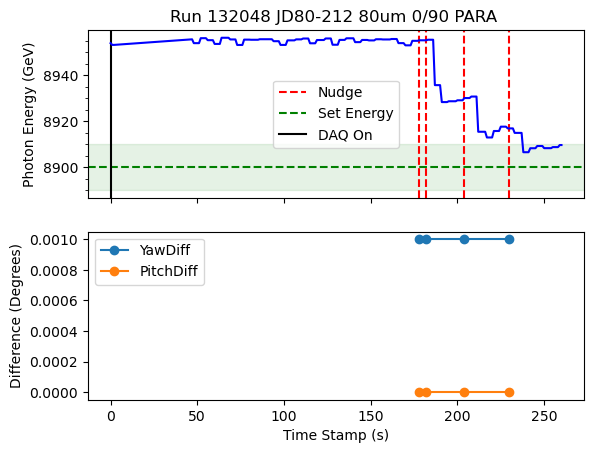

should have  [4] nudges for run 132048
energy change is 46.27399999999943
num_nudges_better is 4.0
energy change per nudge for run  132048 is 11.568499999999858
plotting for run  132093
Total number of nudges this run is  [4]
Nudge list is  [4]
Nudge has backlash count BacklashNudge
False    5965
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5964
True        4
Name: count, dtype: int64
Nudge number 4 occurs at time 398.0
daq on at time 407.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    70
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5891
 0.0       77
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

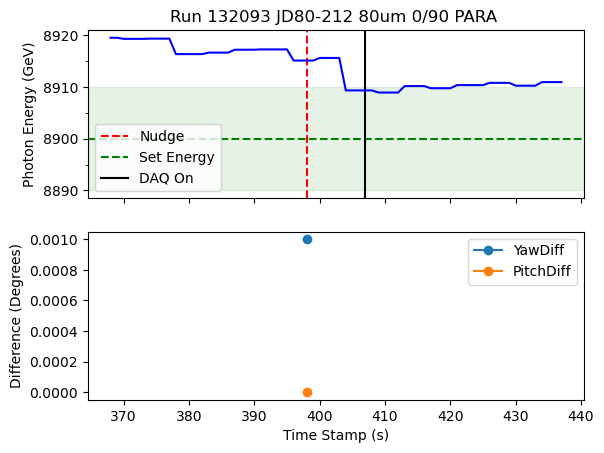

should have  [4] nudges for run 132093
energy change is 4.835000000000946
num_nudges_better is 1.0
energy change per nudge for run  132093 is 4.835000000000946
plotting for run  132095
Total number of nudges this run is  [5]
Nudge list is  [2 3 4 5]
Nudge has backlash count BacklashNudge
False    6402
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6398
True        5
Name: count, dtype: int64
Nudge number 2 occurs at time 127.0
Nudge number 3 occurs at time 129.0
Nudge number 4 occurs at time 147.0
Nudge number 5 occurs at time 148.0
daq on at time 276.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    210
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    6403
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

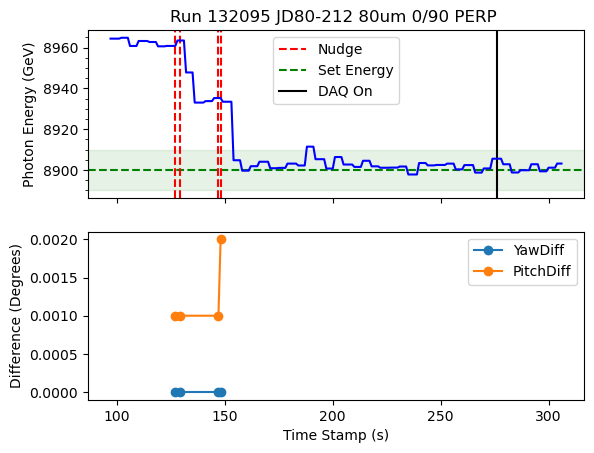

should have  [5] nudges for run 132095
energy change is 58.82999999999993
num_nudges_better is 4.0
energy change per nudge for run  132095 is 14.707499999999982
plotting for run  132108
Total number of nudges this run is  [6]
Nudge list is  [2 3 4 5 6]
Nudge has backlash count BacklashNudge
False    7729
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    7724
True        6
Name: count, dtype: int64
Nudge number 2 occurs at time 361.0
Nudge number 3 occurs at time 382.0
Nudge number 4 occurs at time 401.0
Nudge number 5 occurs at time 422.0
Nudge number 6 occurs at time 461.0
daq on at time 644.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    336
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    7730
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

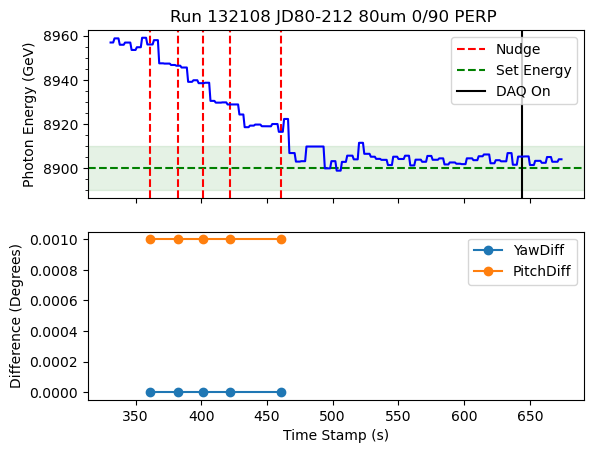

should have  [6] nudges for run 132108
energy change is 49.42499999999927
num_nudges_better is 5.0
energy change per nudge for run  132108 is 9.884999999999854
plotting for run  132111
Total number of nudges this run is  [2]
Nudge list is  [1]
Nudge has backlash count BacklashNudge
False    5636
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5635
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 5.0
daq on at time 124.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    155
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5637
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

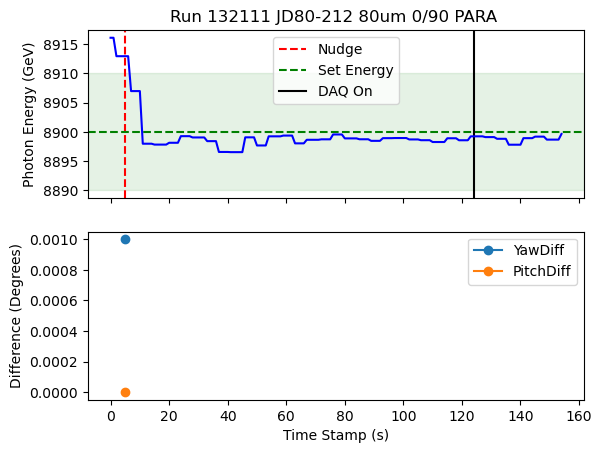

should have  [2] nudges for run 132111
energy change is 14.210000000000946
num_nudges_better is 1.0
energy change per nudge for run  132111 is 14.210000000000946
plotting for run  132127
Total number of nudges this run is  [3]
Nudge list is  [2 3]
Nudge has backlash count BacklashNudge
False    5535
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5533
True        3
Name: count, dtype: int64
Nudge number 2 occurs at time 29.0
Nudge number 3 occurs at time 35.0
daq on at time 180.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    211
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5536
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

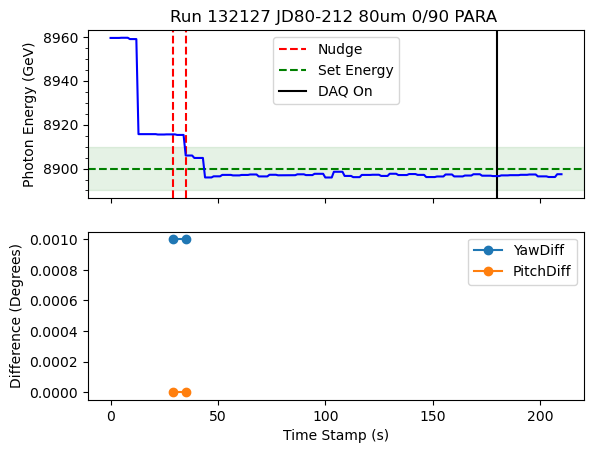

should have  [3] nudges for run 132127
energy change is 18.601999999997133
num_nudges_better is 2.0
energy change per nudge for run  132127 is 9.300999999998567
plotting for run  132145
Total number of nudges this run is  [6]
Nudge list is  [2 3 4 5 6]
Nudge has backlash count BacklashNudge
False    5795
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5790
True        6
Name: count, dtype: int64
Nudge number 2 occurs at time 248.0
Nudge number 3 occurs at time 269.0
Nudge number 4 occurs at time 279.0
Nudge number 5 occurs at time 280.0
Nudge number 6 occurs at time 300.0
daq on at time 327.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    140
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5796
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

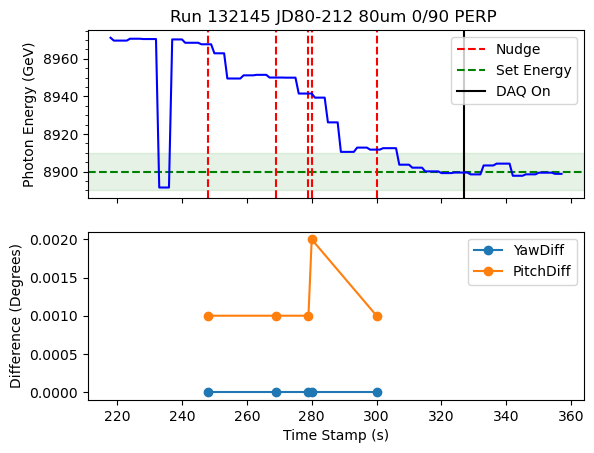

should have  [6] nudges for run 132145
energy change is 68.32750000000124
num_nudges_better is 5.0
energy change per nudge for run  132145 is 13.665500000000247
plotting for run  132158
Total number of nudges this run is  [6]
Nudge list is  [4 5 6]
Nudge has backlash count BacklashNudge
False    5979
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5976
True        6
Name: count, dtype: int64
Nudge number 4 occurs at time 561.0
Nudge number 5 occurs at time 599.0
Nudge number 6 occurs at time 619.0
daq on at time 737.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -16.6
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-16.6    237
Name: count, dtype: int64
roll values are GONI:ROLL
-16.6    5849
 0.0      133
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

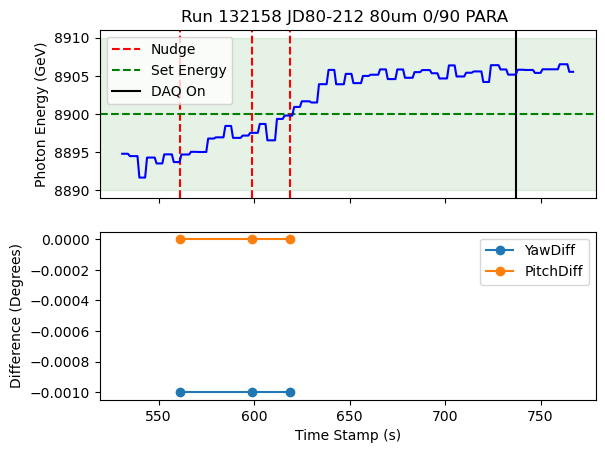

should have  [6] nudges for run 132158
energy change is 11.00250000000051
num_nudges_better is 3.0
energy change per nudge for run  132158 is 3.6675000000001696


<Figure size 640x480 with 0 Axes>

In [18]:
number_nudges = []
energy_changes = []

number_nudges_0_90 = []
energy_changes_0_90 = []

number_nudges_45_135 = []
energy_changes_45_135 = []

# run lists determined by manually looking through plots of all runs, output in cell above
runs_45_135 = [131409, 131662, 131703, 131714, 131734, 131777, 131807, 131825, 131863, 131866, 131918, 131932, 132033, 132061, 132071]
runs_0_90 = [131421, 131602, 131634, 131677, 131771, 131801, 131874, 131891, 131908, 131925, 132009, 132024, 132048, 132093, 132095, 132108, 132111, 132127, 132145, 132158]
good_run_list = runs_45_135+runs_0_90

# some of the runs listed above have unreliable behavior, ie nudges that do nothing, but aren't labeled as backlash
exclude_runs = []
for runNum in good_run_list:
    if runNum in exclude_runs:
        continue

    plot_run(df_2025_good,runNum)

    df_tmp = df_2025_good[(df_2025_good['RunNumber']==runNum)&(df_2025_good['NudgeOccurred'])&(~df_2025_good['BacklashNudge'])]
    df_tmp.reset_index(inplace=True)


    print('should have ',df_tmp['TotalNudges_thisRun'].unique(),'nudges for run',runNum)

    # we are looking at the subset of nudges that are not backlash, so none of these methods work for us
    #num_nudges = df_tmp['TotalNudgeSize_thisRun'].unique()[0]/0.001
    #num_nudges_alt = df_tmp['TotalNudges_thisRun'].unique()[0]
    
    # need to loop over nudge sizes, add in quadrature, and divide by 0.001
    num_nudges_fixed = 0
    for nudgeVal in df_tmp['NudgeNumber'].unique():
        df_tmp2 = df_tmp[df_tmp['NudgeNumber']==nudgeVal]
        num_nudges_fixed += (df_tmp['NudgePitchSize'].mode()[0]**2+df_tmp['NudgeYawSize'].mode()[0]**2)**0.5
    num_nudges_fixed = round(num_nudges_fixed/0.001,1)



    # look at energy at first nudge, compare to avg of last 5 energies
    nudge_list = df_tmp['NudgeNumber'].unique()
    df_first_nudge = df_tmp[df_tmp['NudgeNumber']==min(nudge_list)]
    df_first_nudge.reset_index()
    initial_energy = df_first_nudge.loc[0,'CBREM:ENERGY']


    # look 15-30 seconds after last nudge, take avg time
    df_last_nudge = df_tmp[df_tmp['NudgeNumber']==max(nudge_list)]
    df_last_nudge.reset_index(inplace=True)

    last_nudge_time = df_last_nudge.loc[0,'TimeStamp']

    df_end = df_2025_good[(df_2025_good['RunNumber']==runNum)&(df_2025_good['TimeStamp']>=(last_nudge_time+15))&(df_2025_good['TimeStamp']<=(last_nudge_time+30))]
    end_energies = df_end['CBREM:ENERGY'].unique()

    final_energy = np.mean(end_energies)

    energy_change = abs(final_energy - initial_energy)

    energy_changes.append(energy_change)
    number_nudges.append(num_nudges_fixed)

    print('energy change is',energy_change)
    print('num_nudges_better is',num_nudges_fixed)
    print('energy change per nudge for run ',runNum,'is',energy_change/num_nudges_fixed)

    if runNum in runs_45_135:
        energy_changes_45_135.append(energy_change)
        number_nudges_45_135.append(num_nudges_fixed)
    else:
        energy_changes_0_90.append(energy_change)
        number_nudges_0_90.append(num_nudges_fixed)


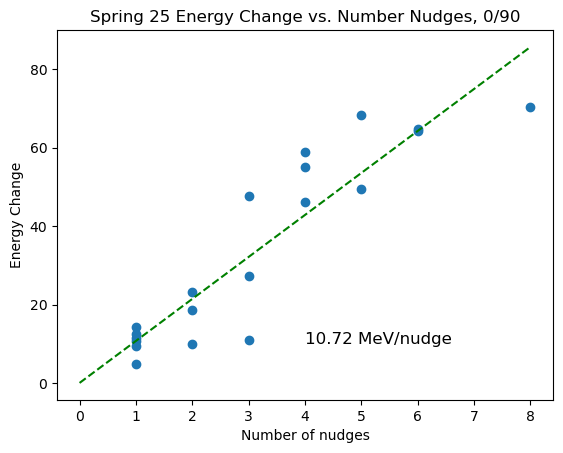

In [19]:
plt.scatter(number_nudges_0_90,energy_changes_0_90)
plt.title("Spring 25 Energy Change vs. Number Nudges, 0/90")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,50)
plt.ylabel("Energy Change")

from sklearn.linear_model import LinearRegression 
lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_0_90).reshape(-1,1)
y = energy_changes_0_90
lr.fit(X,y)

x_vals = np.array(np.arange(0,max(number_nudges_0_90)+1,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_0_90_Spring25.pdf')

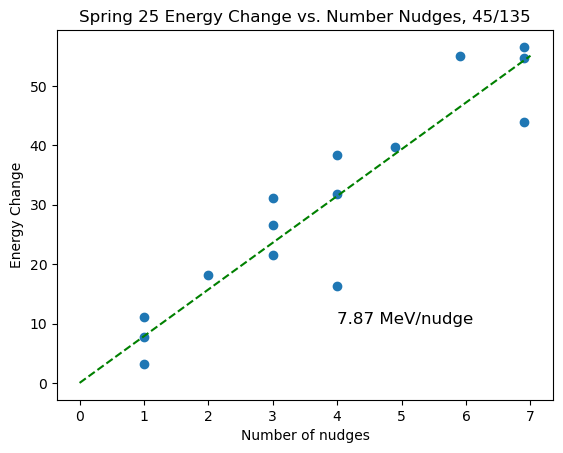

In [20]:
plt.scatter(number_nudges_45_135,energy_changes_45_135)
plt.title("Spring 25 Energy Change vs. Number Nudges, 45/135")
plt.xlabel("Number of nudges")
#plt.xlim(0,6)
#plt.ylim(0,30)
plt.ylabel("Energy Change")

lr = LinearRegression(fit_intercept=False)

X = np.array(number_nudges_45_135).reshape(-1,1)
y = energy_changes_45_135
lr.fit(X,y)

x_vals = np.array(np.arange(0,max(number_nudges_45_135)+1,1)).reshape(-1,1)
y_pred = lr.predict(x_vals)

plt.plot(x_vals,y_pred,color='g',linestyle='--')
plt.text(4.0,10,str(round(lr.coef_[0],2))+" MeV/nudge",fontsize=12)
plt.savefig('plots/multiNudge/energyChange_vs_Nudge_45_135_Spring25.pdf')